In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy.stats as stats
import pprint

np.set_printoptions(precision=3, suppress=True)  # easier to read

In [2]:
# Getting names and values for all categorical columns.
train_df = pd.read_csv('training.csv', index_col='id')
cat_cols = [i for i in train_df if train_df[i].nunique() < 30]
num_cols = [i for i in train_df if i not in cat_cols and i != 'rank' and 'id' not in i]
for col in cat_cols:
    print("    '{}': [{}],".format(col, ', '.join(map(lambda x: "'"+str(x)+"'", train_df[col].unique()))))

    'app_type': ['other', 'forum', 'wiki', 'calendar', 'poll', 'social'],
    'owner_type': ['space', 'user'],
    'is_mentions_me': ['0', '1'],
    'is_mentions_connections': ['0', '1'],
    'is_commented_by_me': ['0', '1'],
    'is_commented_by_connections': ['0', '1'],
    'is_liked_by_me': ['0', '1'],
    'is_liked_by_connections': ['1', '0'],
    'poster_gender': ['male', 'female'],
    'poster_is_employee': ['1', '0'],
    'poster_is_lead': ['0'],
    'poster_is_in_connections': ['1', '0'],
    'poster_focus': ['marketing', 'other', 'engineering', 'sales', 'none'],
    'poster_order': ['6'],
    'participant1_action': ['liked', 'commented', 'viewed'],
    'participant1_gender': ['male', 'female'],
    'participant1_is_employee': ['1', '0'],
    'participant1_is_lead': ['0'],
    'participant1_is_in_connections': ['1', '0'],
    'participant1_focus': ['marketing', 'other', 'engineering', 'sales'],
    'participant1_order': ['5'],
    'participant2_action': ['viewed', 'commented', 

In [3]:
CATEGORIES = {\
    'app_type': ['other', 'forum', 'wiki', 'calendar', 'poll', 'social'],
    'owner_type': ['space', 'user'],
    'is_mentions_me': [0, 1],
    'is_mentions_connections': [0, 1],
    'is_commented_by_me': [0, 1],
    'is_commented_by_connections': [0, 1],
    'is_liked_by_me': [0, 1],
    'is_liked_by_connections': [1, 0],
    'poster_gender': ['male', 'female'],
    'poster_is_employee': [1, 0],
    'poster_is_in_connections': [1, 0],
    'poster_focus': ['marketing', 'other', 'engineering', 'sales', 'none'],
    'participant1_action': ['liked', 'commented', 'viewed'],
    'participant1_gender': ['male', 'female'],
    'participant1_is_employee': [1, 0],
    'participant1_is_in_connections': [1, 0],
    'participant1_focus': ['marketing', 'other', 'engineering', 'sales'],
    'participant2_action': ['viewed', 'commented', 'liked'],
    'participant2_gender': ['male', 'female'],
    'participant2_is_employee': [0, 1],
    'participant2_is_in_connections': [1, 0],
    'participant2_focus': ['other', 'marketing', 'sales', 'engineering'],
    'participant3_action': ['viewed', 'commented', 'liked'],
    'participant3_gender': ['male', 'female'],
    'participant3_is_employee': [0, 1],
    'participant3_is_in_connections': [1, 0],
    'participant3_focus': ['marketing', 'other', 'engineering', 'sales'],
    'participant4_action': ['viewed', 'liked', 'commented'],
    'participant4_gender': ['male', 'female'],
    'participant4_is_employee': [0, 1],
    'participant4_is_in_connections': [1, 0],
    'participant4_focus': ['other', 'marketing', 'sales', 'engineering'],
    'participant5_action': ['viewed', 'liked', 'commented'],
    'participant5_gender': ['male', 'female'],
    'participant5_is_employee': [0, 1],
    'participant5_is_in_connections': [1, 0],
    'participant5_focus': ['other', 'marketing', 'sales', 'engineering']
}

In [4]:
# Dictionaries for chosen double and triple crosses.
double_crosses = {'app_type': ['is_commented_by_connections', 'is_liked_by_connections', 
                             'number_of_comments', 'participant1_is_employee', 'participant1_is_in_connections',
                             'participant1_action', 'participant1_focus', 'participant2_focus', 
                             'participant3_focus', 'participant4_focus', 'participant5_focus'],
                
                'is_commented_by_connections': ['app_type', 'participant2_is_employee', 'participant3_is_employee',
                                                'participant1_action', 'participant2_action', 'participant3_action',
                                                'participant4_action', 'participant5_action', 'participant2_focus',
                                                'participant3_focus', 'participant4_focus'],
                
                'is_liked_by_connections': ['is_commented_by_connections', 'participant1_action',
                                            'participant2_action',  'participant3_action', 'participant4_action',
                                            'participant5_action', 'participant1_focus', 'participant3_focus',
                                            'participant4_focus', 'participant1_is_employee', 
                                            'participant2_is_employee', 'participant3_is_employee',
                                            'participant4_is_employee', 'participant5_is_employee'],
                
                'is_mentions_connections': ['is_commented_by_connections', 'participant4_focus',
                                            'participant1_action', 'participant2_action', 'participant3_action',
                                            'participant4_action', 'participant5_action',
                                            'participant2_is_employee', 'participant3_is_employee',
                                            'participant4_is_employee', 'participant5_is_employee'],
                
                'owner_type': ['app_type', 'number_of_comments', 'number_of_likes', 'owner_influence',
                               'participant3_is_employee', 'participant2_action', 'participant3_action',
                               'participant4_action', 'participant5_action'],
                
                'poster_focus': ['is_commented_by_connections', 'owner_influence', 'poster_influence',
                                 'poster_is_employee', 'poster_is_in_connections', 'participant2_action',
                                 'participant1_focus', 'participant4_focus', 'participant2_is_employee'],
                
                'poster_gender': ['participant2_action', 'participant3_action', 
                                  'participant4_action', 'participant4_focus'],
                
                'poster_is_employee': ['is_commented_by_connections', 'participant4_focus', 
                                       'participant1_is_employee', 'participant2_is_employee', 
                                       'participant3_is_employee', 'poster_is_in_connections'],
                
                'poster_is_in_connections': ['is_commented_by_connections', 'participant2_is_employee',
                                             'poster_focus', 'poster_is_employee'],

                # Participant 1
                'participant1_action': ['app_type', 'number_of_comments', 'number_of_likes', 
                                        'is_commented_by_connections', 'is_liked_by_connections', 
                                        'is_mentions_connections', 'participant1_is_employee', 
                                        'participant2_is_employee', 'participant3_is_employee',
                                        'participant4_is_employee', 'participant5_is_employee',
                                        'participant1_is_in_connections', 'participant2_is_in_connections',
                                        'participant3_is_in_connections', 'participant4_is_in_connections',
                                        'participant5_is_in_connections', 'participant1_focus',
                                        'participant2_focus', 'participant3_focus', 'participant4_focus',
                                        'participant5_focus', 'participant1_gender', 'participant2_gender',
                                        'participant3_gender', 'participant4_gender', 'participant5_gender',
                                        'participant2_action', 'participant3_action', 'participant4_action',
                                        'participant5_action', 'participant1_influence', 'participant2_influence',
                                        'participant3_influence', 'participant4_influence', 'participant5_influence'],
                
                'participant1_focus': ['app_type', 'number_of_comments', 'number_of_likes', 
                                       'is_commented_by_connections', 'is_liked_by_connections', 'owner_influence',
                                       'participant1_action', 'participant2_action', 'participant3_action', 
                                       'participant4_action', 'participant1_influence', 'participant2_influence',
                                       'participant3_influence', 'participant4_influence', 'participant5_influence',
                                       'participant1_is_employee', 'participant2_is_employee', 
                                       'participant3_is_employee', 'participant1_is_in_connections',
                                       'participant3_focus', 'participant4_focus', 'participant5_focus'],
                 
                'participant1_gender': ['number_of_likes', 'owner_influence', 'participant4_focus',
                                        'participant5_focus', 'participant1_action', 'participant2_action',
                                        'participant3_action', 'participant4_action', 'participant3_is_employee',
                                        'poster_gender'],
                
                'participant1_is_employee': ['app_type', 'is_commented_by_connections', 'is_liked_by_connections',
                                             'number_of_comments', 'number_of_likes', 'participant1_action',
                                             'participant2_action', 'participant3_action', 'participant4_action',
                                             'participant1_focus', 'participant3_focus', 'participant4_focus',
                                             'participant5_focus', 'participant1_influence', 'participant2_influence',
                                             'participant3_influence', 'participant4_influence', 'participant5_influence', 
                                             'participant2_is_employee', 'participant3_is_employee'],
                
                'participant1_is_in_connections': ['app_type', 'number_of_comments', 'number_of_likes',
                                                   'participant1_action', 'participant2_action', 'participant3_action',
                                                   'participant1_focus', 'participant4_focus', 'participant1_is_employee',
                                                   'participant2_is_employee', 'participant3_is_employee',
                                                   'participant2_influence', 'participant4_influence', 'participant5_influence'],

                # Participant 2
                'participant2_action': ['app_type', 'is_commented_by_connections', 'is_liked_by_connections',
                                        'is_mentions_connections', 'number_of_comments', 'number_of_likes',
                                        'owner_influence', 'participant1_action', 'participant3_action',
                                        'participant4_action', 'participant5_action', 'participant1_focus',
                                        'participant2_focus', 'participant3_focus', 'participant4_focus',
                                        'participant1_influence', 'participant2_influence', 'participant3_influence',
                                        'participant4_influence', 'participant5_influence',
                                        'participant1_is_employee', 'participant2_is_employee', 
                                        'participant3_is_employee', 'participant4_is_employee', 
                                        'participant5_is_employee', 'participant2_gender', 'participant3_gender', 
                                        'participant4_gender', 'participant5_gender', 
                                        'participant2_is_in_connections', 'participant3_is_in_connections',
                                        'participant4_is_in_connections', 'participant5_is_in_connections'],
                
                'participant2_focus': ['number_of_comments', 'number_of_likes', 'owner_influence',
                                       'participant1_action', 'participant2_action', 'participant1_influence',
                                       'participant2_influence', 'participant3_influence', 'participant4_influence',
                                       'participant5_influence', 'participant2_is_employee', 
                                       'participant3_is_employee', 'participant4_focus', 'participant5_focus'],
                
                'participant2_gender': ['is_commented_by_connections', 'number_of_comments', 'number_of_likes',
                                        'owner_influence', 'participant1_action', 'participant2_action', 'participant3_action',
                                        'participant4_action', 'participant5_action', 'participant1_influence',
                                        'participant2_influence', 'participant3_influence', 'participant4_influence',
                                        'participant5_influence', 'participant2_is_employee', 'participant3_is_employee',
                                        'participant4_is_employee', 'participant4_focus'],
                
                'participant2_is_employee': ['is_commented_by_connections', 'is_liked_by_connections', 'number_of_comments',
                                             'number_of_likes', 'participant1_action', 'participant2_action',
                                             'participant3_action', 'participant4_action', 'participant5_action',
                                             'participant1_focus', 'participant3_focus', 'participant4_focus',
                                             'participant1_influence', 'participant2_influence', 'participant3_influence',
                                             'participant4_influence', 'participant5_influence', 'participant1_is_employee',
                                             'participant3_is_employee', 'participant4_is_employee'],
                
                'participant2_is_in_connections': ['is_commented_by_connections', 'number_of_comments', 'number_of_likes',
                                                   'participant1_action', 'participant2_action', 'participant3_action',
                                                   'participant4_action', 'participant5_action', 'participant1_influence',
                                                   'participant2_influence', 'participant3_influence', 'participant4_influence',
                                                   'participant5_influence', 'participant3_is_employee', 
                                                   'participant4_is_employee', 'participant4_focus'],
                
                # Participant 3
                'participant3_action': ['app_type', 'is_commented_by_connections', 'is_liked_by_connections',
                                        'is_mentions_connections', 'number_of_comments', 'number_of_likes',
                                        'owner_influence', 'participant1_action', 'participant2_action',
                                        'participant4_action', 'participant5_action', 'participant1_focus',
                                        'participant3_focus', 'participant4_focus', 'participant5_focus',
                                        'participant1_influence', 'participant2_influence', 'participant3_influence',
                                        'participant4_influence', 'participant5_influence', 'participant1_is_employee',
                                        'participant2_is_employee', 'participant3_is_employee', 'participant4_is_employee',
                                        'participant5_is_employee', 'participant3_gender', 'participant4_gender',
                                        'participant5_gender', 'participant3_is_in_connections', 'participant4_is_in_connections',
                                        'participant5_is_in_connections'],
                
                'participant3_focus': ['is_commented_by_connections', 'is_liked_by_connections', 'number_of_comments',
                                       'number_of_likes', 'owner_influence', 'participant1_action', 'participant2_action',
                                       'participant3_action', 'participant4_action', 'participant1_focus', 'participant4_focus',
                                       'participant1_influence', 'participant2_influence', 'participant3_influence',
                                       'participant4_influence', 'participant5_influence', 'participant1_is_employee',
                                       'participant2_is_employee', 'participant3_is_employee'],
                
                'participant3_gender': ['is_commented_by_connections', 'number_of_comments', 'number_of_likes', 'owner_influence',
                                        'participant1_action', 'participant2_action', 'participant3_action', 
                                        'participant4_action', 'participant5_action', 'participant1_influence', 
                                        'participant2_influence', 'participant3_influence', 'participant4_influence',
                                        'participant5_influence', 'participant3_is_employee', 'participant4_is_employee', 
                                        'participant5_is_employee', 'participant4_focus'],
                
                'participant3_is_employee': ['is_commented_by_connections', 'is_liked_by_connections', 'number_of_comments',
                                             'number_of_likes', 'owner_influence', 'participant1_action', 'participant2_action',
                                             'participant3_action', 'participant4_action', 'participant5_action',
                                             'participant1_focus', 'participant3_focus', 'participant4_focus',
                                             'participant5_focus', 'participant1_influence', 'participant2_influence',
                                             'participant3_influence', 'participant4_influence', 'participant5_influence',
                                             'participant1_is_employee', 'participant2_is_employee', 'participant4_is_employee',
                                             'participant5_is_employee'],
                
                'participant3_is_in_connections': ['is_commented_by_connections', 'number_of_comments', 'number_of_likes',
                                                   'participant1_action', 'participant2_action', 'participant3_action',
                                                   'participant4_action', 'participant5_action', 'participant1_focus',
                                                   'participant4_focus', 'participant1_influence', 'participant2_influence',
                                                   'participant3_influence', 'participant4_influence', 'participant5_influence',
                                                   'participant2_is_employee', 'participant3_is_employee', 
                                                   'participant4_is_employee', 'participant5_is_employee'],
               
                # Participant 4
                'participant4_action': ['is_commented_by_connections', 'is_liked_by_connections', 'is_mentions_connections',
                                        'number_of_comments', 'number_of_likes', 'owner_influence', 'participant1_action',
                                        'participant2_action', 'participant3_action', 'participant5_action', 'participant1_focus',
                                        'participant3_focus', 'participant4_focus', 'participant5_focus', 'participant1_influence',
                                        'participant2_influence', 'participant3_influence', 'participant4_influence',
                                        'participant5_influence', 'participant1_is_employee', 'participant2_is_employee',
                                        'participant3_is_employee', 'participant4_is_employee', 'participant5_is_employee',
                                        'participant4_gender', 'participant5_gender', 'participant4_is_in_connections',
                                        'participant5_is_in_connections'],
                
                'participant4_focus': ['is_commented_by_connections', 'is_liked_by_connections', 'number_of_comments',
                                       'number_of_likes', 'owner_influence', 'participant1_action', 'participant2_action',
                                       'participant3_action', 'participant4_action', 'participant5_action', 'participant1_focus',
                                       'participant5_focus', 'participant1_influence', 'participant2_influence', 
                                       'participant3_influence', 'participant4_influence', 'participant5_influence',
                                       'participant1_is_employee', 'participant2_is_employee', 'participant3_is_employee',
                                       'participant4_is_employee', 'participant5_is_employee'],
                
                'participant4_gender': ['is_commented_by_connections', 'number_of_comments', 'number_of_likes', 'owner_influence',
                                        'participant1_action', 'participant2_action', 'participant3_action', 'participant4_action',
                                        'participant5_action', 'participant1_influence', 'participant2_influence', 
                                        'participant3_is_employee', 'participant4_is_employee', 'participant5_is_employee',
                                        'participant4_focus'],
                
                'participant4_is_employee': ['is_commented_by_connections', 'is_liked_by_connections', 'number_of_comments',
                                             'number_of_likes', 'participant1_action', 'participant2_action', 'participant3_action',
                                             'participant4_action', 'participant5_action', 'participant1_influence',
                                             'participant2_influence', 'participant3_influence', 'participant4_influence',
                                             'participant5_influence', 'participant1_is_employee', 'participant2_is_employee', 
                                             'participant3_is_employee', 'participant5_is_employee', 'participant3_focus', 
                                             'participant4_focus'],
                
                'participant4_is_in_connections': ['is_commented_by_connections', 'number_of_comments', 'number_of_likes',
                                                   'participant1_action', 'participant2_action', 'participant3_action', 
                                                   'participant4_action', 'participant5_action', 'participant1_influence',
                                                   'participant2_influence', 'participant3_influence', 'participant4_influence',
                                                   'participant5_influence', 'participant2_is_employee', 'participant3_is_employee',
                                                   'participant4_is_employee', 'participant5_is_employee', 'participant4_focus'],
                
                # Participant 5
                'participant5_action': ['is_commented_by_connections', 'is_liked_by_connections', 'is_mentions_connections', 
                                        'number_of_comments', 'number_of_likes', 'owner_influence', 'participant1_action',
                                        'participant2_action', 'participant3_action', 'participant4_action', 'participant1_focus',
                                        'participant3_focus', 'participant4_focus', 'participant5_focus', 'participant1_influence',
                                        'participant2_influence', 'participant3_influence', 'participant4_influence',
                                        'participant5_influence', 'participant1_is_employee', 'participant2_is_employee',
                                        'participant3_is_employee', 'participant4_is_employee', 'participant5_is_employee',
                                        'participant5_gender', 'participant5_is_in_connections'],
                
                'participant5_focus': ['number_of_comments', 'number_of_likes', 'owner_influence', 'participant1_action',
                                       'participant2_action', 'participant3_action', 'participant1_influence',
                                       'participant2_influence', 'participant3_influence', 'participant4_influence',
                                       'participant5_influence', 'participant1_is_employee', 'participant3_is_employee',
                                       'participant2_focus', 'participant4_focus'],
                
                'participant5_gender': ['is_commented_by_connections', 'number_of_comments', 'number_of_likes', 
                                        'participant1_action', 'participant2_action', 'participant3_action', 'participant4_action',
                                        'participant5_action', 'participant1_influence', 'participant2_influence', 
                                        'participant3_influence', 'participant4_influence', 'participant5_influence',
                                        'participant3_is_employee', 'participant4_is_employee', 'participant5_is_employee',
                                        'participant4_focus'],
                
                'participant5_is_employee': ['is_commented_by_connections', 'is_liked_by_connections', 'number_of_comments', 
                                             'number_of_likes', 'participant1_action', 'participant2_action', 'participant3_action',
                                             'participant4_action', 'participant5_action', 'participant1_influence',
                                             'participant2_influence', 'participant3_influence', 'participant4_influence',
                                             'participant5_influence', 'participant2_is_employee', 'participant3_is_employee',
                                             'participant4_is_employee', 'participant3_focus', 'participant4_focus', 
                                             'participant5_focus'],
                
                'participant5_is_in_connections': ['is_commented_by_connections', 'number_of_comments', 'number_of_likes',
                                                   'participant1_action', 'participant2_action', 'participant3_action', 
                                                   'participant4_action', 'participant5_action', 'participant1_influence',
                                                   'participant2_influence', 'participant3_influence', 'participant4_influence',
                                                   'participant5_influence', 'participant3_is_employee', 'participant4_is_employee',
                                                   'participant5_is_employee', 'participant4_focus']}

triple_crosses = \
{'app_type': {'is_liked_by_connections': ['participant1_action',
                                          'participant2_action',
                                          'participant3_action',
                                          'participant4_action',
                                          'participant3_focus'],
              'participant1_is_employee': ['participant1_focus',
                                           'participant2_action',
                                           'participant2_influence'],
              'participant1_is_in_connections': ['number_of_comments'],
              'participant2_action': ['is_commented_by_connections',
                                      'is_liked_by_connections',
                                      'number_of_comments',
                                      'participant1_action',
                                      'participant3_action',
                                      'participant4_action',
                                      'participant5_action',
                                      'participant1_focus',
                                      'participant3_focus',
                                      'participant4_focus',
                                      'participant2_influence',
                                      'participant3_influence',
                                      'participant4_influence',
                                      'participant5_influence'],
              'participant3_action': ['number_of_comments',
                                      'participant1_action',
                                      'participant2_action',
                                      'participant4_action',
                                      'participant5_action',
                                      'participant1_is_employee',
                                      'participant2_is_employee',
                                      'participant3_focus',
                                      'participant4_focus']},
 'is_commented_by_connections': {'participant1_action': ['participant2_action',
                                                         'participant3_action',
                                                         'participant3_is_employee',
                                                         'participant4_is_employee',
                                                         'participant5_focus'],
                                 'participant2_action': ['is_liked_by_connections',
                                                         'number_of_comments',
                                                         'number_of_likes',
                                                         'participant1_focus',
                                                         'participant1_is_employee',
                                                         'participant2_is_employee',
                                                         'participant3_is_employee',
                                                         'participant4_is_employee',
                                                         'participant5_is_employee',
                                                         'participant2_influence',
                                                         'participant3_influence',
                                                         'participant4_influence',
                                                         'participant5_influence',
                                                         'participant3_action',
                                                         'participant4_action',
                                                         'participant5_action'],
                                 'participant3_action': ['number_of_comments',
                                                         'participant1_is_employee',
                                                         'participant2_action',
                                                         'participant4_action',
                                                         'participant5_action',
                                                         'participant3_focus',
                                                         'participant4_focus'],
                                 'participant3_focus': ['is_liked_by_connections',
                                                        'participant2_action',
                                                        'participant4_action',
                                                        'participant2_is_employee',
                                                        'participant3_is_employee'],
                                 'participant4_focus': ['is_liked_by_connections',
                                                        'participant2_action',
                                                        'participant3_action',
                                                        'participant4_action',
                                                        'participant5_action',
                                                        'participant3_is_employee',
                                                        'participant4_is_employee'],
                                 'participant5_action': ['number_of_likes',
                                                         'participant2_action',
                                                         'participant3_action',
                                                         'participant4_action',
                                                         'participant2_is_employee',
                                                         'participant3_focus',
                                                         'participant4_focus',
                                                         'participant5_focus']},
 'is_liked_by_connections': {'participant1_action': ['is_commented_by_connections',
                                                     'number_of_comments',
                                                     'participant2_action',
                                                     'participant3_action',
                                                     'participant3_influence',
                                                     'participant4_influence',
                                                     'participant5_influence'],
                             'participant1_focus': ['is_commented_by_connections',
                                                    'participant1_is_employee',
                                                    'participant2_is_employee',
                                                    'participant3_is_employee',
                                                    'participant2_action',
                                                    'participant3_action',
                                                    'participant3_focus'],
                             'participant1_is_employee': ['participant1_focus',
                                                          'participant3_focus',
                                                          'participant2_action',
                                                          'participant3_action',
                                                          'participant2_is_employee',
                                                          'participant3_is_employee'],
                             'participant2_action': ['is_commented_by_connections',
                                                     'number_of_comments',
                                                     'participant1_action',
                                                     'participant3_action',
                                                     'participant4_action',
                                                     'participant5_action',
                                                     'participant1_is_employee',
                                                     'participant2_is_employee',
                                                     'participant3_is_employee',
                                                     'participant4_is_employee',
                                                     'participant5_is_employee',
                                                     'participant2_influence',
                                                     'participant3_influence',
                                                     'participant4_influence',
                                                     'participant5_influence',
                                                     'participant3_focus',
                                                     'participant4_focus'],
                             'participant2_is_employee': ['participant2_action'],
                             'participant3_action': ['is_commented_by_connections',
                                                     'number_of_comments',
                                                     'participant1_action',
                                                     'participant2_action',
                                                     'participant5_action',
                                                     'participant1_is_employee',
                                                     'participant4_is_employee',
                                                     'participant3_focus',
                                                     'participant4_focus'],
                             'participant3_focus': ['participant1_is_employee',
                                                    'participant2_is_employee',
                                                    'participant2_action',
                                                    'participant4_action'],
                             'participant3_is_employee': ['participant2_is_employee'],
                             'participant4_action': ['is_commented_by_connections',
                                                     'participant1_action',
                                                     'participant2_action',
                                                     'participant1_focus',
                                                     'participant3_focus',
                                                     'participant4_focus',
                                                     'participant1_is_employee',
                                                     'participant2_is_employee',
                                                     'participant5_is_employee'],
                             'participant4_focus': ['is_commented_by_connections',
                                                    'participant1_is_employee',
                                                    'participant3_is_employee',
                                                    'participant2_action',
                                                    'participant3_action',
                                                    'participant5_action'],
                             'participant5_action': ['is_commented_by_connections',
                                                     'participant2_action',
                                                     'participant3_action',
                                                     'participant2_is_employee',
                                                     'participant3_focus',
                                                     'participant4_focus',
                                                     'participant5_focus']},
 'is_mentions_connections': {'is_commented_by_connections': ['participant1_action',
                                                             'participant2_action',
                                                             'participant3_action'],
                             'participant1_action': ['number_of_comments',
                                                     'participant3_is_employee',
                                                     'participant4_is_employee',
                                                     'participant5_focus'],
                             'participant2_action': ['is_commented_by_connections',
                                                     'is_liked_by_connections',
                                                     ' number_of_comments',
                                                     ' number_of_likes',
                                                     'participant3_action',
                                                     'participant4_action',
                                                     'participant5_action',
                                                     'participant2_influence',
                                                     'participant3_influence',
                                                     'participant4_influence',
                                                     'participant5_influence'],
                             'participant3_action': ['is_commented_by_connections',
                                                     'number_of_comments',
                                                     'participant2_action',
                                                     'participant3_focus',
                                                     'participant4_focus'],
                             'participant3_is_employee': ['is_commented_by_connections',
                                                          'number_of_comments',
                                                          'participant2_action',
                                                          'participant4_action'],
                             'participant4_focus': ['participant2_action',
                                                    'participant4_action',
                                                    'participant5_action'],
                             'participant4_is_employee': ['participant2_action',
                                                          'participant5_action']},
 'owner_type': {'participant2_action': ['is_commented_by_connections',
                                        'is_liked_by_connections',
                                        'number_of_comments',
                                        'number_of_likes',
                                        'participant1_action',
                                        'participant4_action',
                                        'participant5_action',
                                        'participant1_focus',
                                        'participant3_focus',
                                        'participant4_focus',
                                        'participant1_is_employee',
                                        'participant3_is_employee',
                                        'participant4_is_employee',
                                        'participant5_is_employee',
                                        'participant2_influence',
                                        'participant3_influence',
                                        'participant4_influence',
                                        'participant5_influence'],
                'participant5_action': ['is_commented_by_connections',
                                        'number_of_likes',
                                        'participant2_action',
                                        'participant3_action',
                                        'participant2_influence',
                                        'participant3_influence',
                                        'participant4_influence',
                                        'participant5_influence',
                                        'participant2_is_employee',
                                        'participant3_is_employee',
                                        'participant4_is_employee',
                                        'participant5_is_employee',
                                        'participant3_focus',
                                        'participant5_focus']},
 'participant1_action': {'is_commented_by_connections': ['participant2_action',
                                                         'participant3_action',
                                                         'participant3_focus'],
                         'is_liked_by_connections': ['participant3_focus',
                                                     'participant4_focus'],
                         'is_mentions_connections': ['is_commented_by_connections',
                                                     'participant2_action',
                                                     'participant3_action',
                                                     'participant3_is_employee'],
                         'participant2_action': ['is_commented_by_connections',
                                                 'number_of_comments',
                                                 'number_of_likes',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant4_action'],
                         'participant3_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'number_of_comments',
                                                 'participant2_action',
                                                 'participant3_focus'],
                         'participant3_is_employee': ['is_liked_by_connections',
                                                      'number_of_comments',
                                                      'number_of_likes',
                                                      'participant3_focus'],
                         'participant4_is_employee': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'number_of_comments',
                                                      'number_of_likes',
                                                      'participant2_action',
                                                      'participant2_is_employee'],
                         'participant5_focus': ['number_of_comments',
                                                'number_of_likes',
                                                'participant1_is_employee']},
 'participant1_focus': {'is_commented_by_connections': ['participant1_action',
                                                        'participant2_action',
                                                        'participant3_action',
                                                        'participant4_focus'],
                        'is_liked_by_connections': ['participant1_action',
                                                    'participant2_action',
                                                    'participant1_is_employee',
                                                    'participant4_focus'],
                        'participant1_is_employee': ['is_commented_by_connections',
                                                     'participant1_influence',
                                                     'participant2_action',
                                                     'participant3_action'],
                        'participant2_action': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'number_of_comments',
                                                'number_of_likes',
                                                'participant1_action',
                                                'participant3_action',
                                                'participant4_action',
                                                'participant5_action',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant3_is_employee',
                                                'participant4_is_employee',
                                                'participant5_is_employee'],
                        'participant2_is_employee': ['participant2_action',
                                                     'participant4_focus'],
                        'participant3_action': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'number_of_comments',
                                                'participant1_action',
                                                'participant2_action',
                                                'participant4_action',
                                                'participant5_action',
                                                'participant1_is_employee',
                                                'participant4_focus'],
                        'participant3_focus': ['is_liked_by_connections',
                                               'participant1_is_employee',
                                               'participant2_is_employee',
                                               'participant3_is_employee',
                                               'participant2_action',
                                               'participant4_action'],
                        'participant3_is_employee': ['participant2_action',
                                                     'participant4_focus'],
                        'participant4_focus': ['is_commented_by_connections',
                                               'participant1_is_employee',
                                               'participant2_is_employee',
                                               'participant3_is_employee',
                                               'participant4_is_employee',
                                               'participant3_action',
                                               'participant4_action',
                                               'participant5_action']},
 'participant1_gender': {'participant1_action': ['participant3_action',
                                                 'participant5_focus'],
                         'participant2_action': ['number_of_likes',
                                                 'participant2_influence',
                                                 'participant3_influence',
                                                 'participant4_influence',
                                                 'participant5_influence',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant3_action',
                                                 'participant4_action',
                                                 'participant3_focus',
                                                 'participant4_focus'],
                         'participant3_action': ['is_commented_by_connections',
                                                 'number_of_comments',
                                                 'number_of_likes',
                                                 'participant1_action',
                                                 'participant2_action',
                                                 'participant5_action',
                                                 'participant2_influence',
                                                 'participant3_influence',
                                                 'participant4_influence',
                                                 'participant5_influence',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant3_focus',
                                                 'participant4_focus'],
                         'participant3_is_employee': ['participant3_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant3_focus'],
                         'participant4_action': ['number_of_comments',
                                                 'number_of_likes',
                                                 'participant1_action',
                                                 'participant5_action',
                                                 'participant2_influence',
                                                 'participant3_influence',
                                                 'participant4_influence',
                                                 'participant5_influence',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant3_focus',
                                                 'participant4_focus'],
                         'participant4_focus': ['participant2_action',
                                                'participant3_action',
                                                'participant4_action',
                                                'participant5_action'],
                         'participant5_focus': ['participant3_is_employee']},
 'participant1_is_employee': {'is_commented_by_connections': ['participant1_action',
                                                              'participant2_action',
                                                              'participant4_focus'],
                              'is_liked_by_connections': ['participant1_action',
                                                          'participant2_action',
                                                          'participant4_action',
                                                          'participant4_focus'],
                              'participant1_focus': ['participant1_influence',
                                                     'participant2_action',
                                                     'participant3_action'],
                              'participant2_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'number_of_comments',
                                                      'participant2_influence',
                                                      'participant3_influence',
                                                      'participant4_influence',
                                                      'participant5_influence',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant4_is_employee',
                                                      'participant3_action',
                                                      'participant4_action'],
                              'participant2_is_employee': ['participant2_action',
                                                           'participant4_focus'],
                              'participant3_action': ['participant1_action',
                                                      'participant2_action',
                                                      'participant4_action',
                                                      'participant3_focus',
                                                      'participant4_focus'],
                              'participant3_focus': ['participant3_is_employee'],
                              'participant3_is_employee': ['participant2_action',
                                                           'participant4_focus'],
                              'participant4_focus': ['is_commented_by_connections',
                                                     'participant2_influence',
                                                     'participant3_influence',
                                                     'participant4_influence',
                                                     'participant5_influence',
                                                     'participant2_is_employee',
                                                     'participant3_is_employee',
                                                     'participant4_is_employee',
                                                     'participant3_action',
                                                     'participant4_action',
                                                     'participant5_action']},
 'participant1_is_in_connections': {'app_type': ['is_liked_by_connections',
                                                 ' participant1_is_employee',
                                                 'participant2_action',
                                                 'participant3_action'],
                                    'participant1_focus': ['number_of_comments',
                                                           'number_of_likes',
                                                           'participant1_influence',
                                                           'participant3_influence',
                                                           'participant1_is_employee',
                                                           'participant3_action'],
                                    'participant1_is_employee': ['is_commented_by_connections',
                                                                 'participant1_focus'],
                                    'participant2_action': ['is_commented_by_connections',
                                                            'is_liked_by_connections',
                                                            'number_of_comments',
                                                            'number_of_likes',
                                                            'participant1_action',
                                                            'participant3_action',
                                                            'participant4_action',
                                                            'participant1_focus',
                                                            'participant3_focus',
                                                            'participant4_focus',
                                                            'participant2_influence',
                                                            'participant3_influence',
                                                            'participant4_influence',
                                                            'participant5_influence',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee'],
                                    'participant3_action': ['participant1_action',
                                                            'participant2_action',
                                                            'participant3_focus',
                                                            'participant4_focus']},
 'participant2_action': {'is_commented_by_connections': ['participant1_action',
                                                         'participant3_action',
                                                         'participant5_action',
                                                         'participant4_focus'],
                         'is_liked_by_connections': ['participant1_action',
                                                     'participant3_action',
                                                     'participant4_action',
                                                     'participant5_action',
                                                     'participant1_focus',
                                                     'participant2_is_employee',
                                                     'participant3_is_employee',
                                                     'participant4_is_employee'],
                         'is_mentions_connections': ['is_commented_by_connections',
                                                     'participant1_action',
                                                     'participant3_action',
                                                     'participant3_is_employee',
                                                     'participant4_is_employee'],
                         'participant1_action': ['is_commented_by_connections',
                                                 'number_of_comments',
                                                 'number_of_likes',
                                                 'participant3_action',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee'],
                         'participant1_focus': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant3_is_employee',
                                                'participant3_action'],
                         'participant1_is_employee': ['is_commented_by_connections',
                                                      'participant1_focus',
                                                      'participant4_focus',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant3_action'],
                         'participant2_is_employee': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant3_action',
                                                      'participant3_is_employee',
                                                      'participant4_is_employee'],
                         'participant3_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'number_of_likes',
                                                 'participant1_is_employee',
                                                 'participant4_is_employee',
                                                 'participant4_influence',
                                                 'participant5_influence'],
                         'participant3_focus': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'participant1_action',
                                                'participant1_focus',
                                                'participant2_is_employee',
                                                'participant3_is_employee'],
                         'participant3_is_employee': ['is_commented_by_connections',
                                                      'participant2_is_employee',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant4_focus'],
                         'participant4_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'number_of_likes',
                                                 'participant1_action',
                                                 'participant5_action',
                                                 'participant1_focus',
                                                 'participant3_influence',
                                                 'participant4_influence',
                                                 'participant5_influence',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee'],
                         'participant4_focus': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'participant1_focus',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant4_is_employee',
                                                'participant3_action',
                                                'participant4_action'],
                         'participant4_is_employee': ['is_commented_by_connections',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant5_action'],
                         'participant5_action': ['is_commented_by_connections',
                                                 'number_of_likes',
                                                 'participant3_action',
                                                 'participant4_focus',
                                                 'participant5_focus',
                                                 'participant3_influence',
                                                 'participant4_influence',
                                                 'participant5_influence',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee'],
                         'participant5_is_employee': ['is_commented_by_connections',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant4_focus',
                                                      'participant5_focus']},
 'participant2_focus': {'participant2_action': ['is_commented_by_connections',
                                                'number_of_comments',
                                                'number_of_likes',
                                                'participant1_action',
                                                'participant3_action',
                                                'participant4_action',
                                                'participant1_focus',
                                                'participant3_focus',
                                                'participant2_influence',
                                                'participant3_influence',
                                                'participant4_influence',
                                                'participant5_influence',
                                                'participant2_is_employee',
                                                'participant3_is_employee'],
                        'participant2_is_employee': ['participant2_action',
                                                     'participant2_influence',
                                                     'participant4_focus'],
                        'participant4_focus': ['is_commented_by_connections',
                                               'participant1_focus',
                                               'participant2_influence',
                                               'participant3_influence',
                                               'participant4_influence',
                                               'participant5_influence',
                                               'participant2_is_employee',
                                               'participant3_is_employee',
                                               'participant4_is_employee',
                                               'participant3_action',
                                               'participant4_action',
                                               'participant5_action'],
                        'participant5_focus': ['participant1_action',
                                               'participant2_influence',
                                               'participant3_influence',
                                               'participant5_influence']},
 'participant2_gender': {'participant2_is_employee': ['participant2_action',
                                                      'participant3_action',
                                                      'participant4_focus'],
                         'participant3_action': ['is_liked_by_connections',
                                                 'number_of_likes',
                                                 'participant1_action',
                                                 'participant2_action',
                                                 'participant4_action',
                                                 'participant5_action',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant3_influence',
                                                 'participant4_influence',
                                                 'participant5_influence'],
                         'participant3_is_employee': ['participant2_action',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant5_action'],
                         'participant4_action': ['is_liked_by_connections',
                                                 'number_of_comments',
                                                 'number_of_likes',
                                                 'participant1_action',
                                                 'participant2_action',
                                                 'participant3_action',
                                                 'participant1_focus',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant3_influence',
                                                 'participant4_influence',
                                                 'participant5_influence'],
                         'participant4_is_employee': ['participant2_action',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant4_focus'],
                         'participant5_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'number_of_comments',
                                                 'number_of_likes',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant5_focus',
                                                 'participant3_influence',
                                                 'participant4_influence',
                                                 'participant5_influence']},
 'participant2_is_employee': {'is_commented_by_connections': ['participant1_action',
                                                              'participant2_action',
                                                              'participant3_action'],
                              'is_liked_by_connections': ['participant1_action',
                                                          'participant3_action',
                                                          'participant4_action',
                                                          'participant1_focus',
                                                          'participant3_focus',
                                                          'participant3_is_employee'],
                              'participant1_focus': ['is_commented_by_connections',
                                                     'number_of_comments',
                                                     'number_of_likes',
                                                     'participant1_is_employee',
                                                     'participant3_is_employee',
                                                     'participant3_action'],
                              'participant2_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant1_action',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant1_focus',
                                                      'participant4_focus',
                                                      'participant1_is_employee',
                                                      'participant3_is_employee'],
                              'participant3_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'number_of_comments',
                                                      'participant1_action',
                                                      'participant2_action',
                                                      'participant4_action',
                                                      'participant1_is_employee',
                                                      'participant3_focus',
                                                      'participant4_focus'],
                              'participant3_is_employee': ['participant2_action',
                                                           'participant5_action',
                                                           'participant3_focus'],
                              'participant4_focus': ['is_commented_by_connections',
                                                     'is_liked_by_connections',
                                                     'participant1_focus',
                                                     'participant1_is_employee',
                                                     'participant3_is_employee',
                                                     'participant4_is_employee',
                                                     'participant2_action',
                                                     'participant3_action',
                                                     'participant4_action'],
                              'participant4_is_employee': ['is_commented_by_connections',
                                                           'is_liked_by_connections',
                                                           'participant2_action',
                                                           'participant4_focus'],
                              'participant5_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'number_of_comments',
                                                      'participant2_action',
                                                      'participant3_focus',
                                                      'participant4_focus',
                                                      'participant5_focus']},
 'participant2_is_in_connections': {'participant2_action': ['is_liked_by_connections',
                                                            'number_of_likes',
                                                            'participant1_action',
                                                            'participant1_focus',
                                                            'participant3_focus',
                                                            'participant4_focus',
                                                            'participant1_is_employee',
                                                            'participant3_is_employee',
                                                            'participant2_influence',
                                                            'participant3_influence',
                                                            'participant4_influence',
                                                            'participant5_influence'],
                                    'participant3_action': ['is_liked_by_connections',
                                                            'number_of_likes',
                                                            'participant1_action',
                                                            'participant4_action',
                                                            'participant1_is_employee',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee',
                                                            'participant5_is_employee',
                                                            'participant2_influence',
                                                            'participant3_influence',
                                                            'participant4_influence',
                                                            'participant5_influence',
                                                            'participant3_focus',
                                                            'participant4_focus'],
                                    'participant3_is_employee': ['participant2_action',
                                                                 'participant3_action',
                                                                 'participant4_action',
                                                                 'participant5_action',
                                                                 'participant4_focus'],
                                    'participant4_action': ['is_commented_by_connections',
                                                            'is_liked_by_connections',
                                                            'number_of_comments',
                                                            'number_of_likes',
                                                            'participant1_action',
                                                            'participant2_action',
                                                            'participant3_action',
                                                            'participant1_focus',
                                                            'participant3_focus',
                                                            'participant4_focus',
                                                            'participant1_is_employee',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee',
                                                            'participant5_is_employee',
                                                            'participant3_influence',
                                                            'participant4_influence',
                                                            'participant5_influence'],
                                    'participant4_is_employee': ['participant2_action',
                                                                 'participant4_action',
                                                                 'participant5_action',
                                                                 'participant4_focus'],
                                    'participant5_action': ['is_commented_by_connections',
                                                            'is_liked_by_connections',
                                                            'number_of_comments',
                                                            'number_of_likes',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee',
                                                            'participant5_is_employee',
                                                            'participant3_focus',
                                                            'participant4_focus',
                                                            'participant5_focus',
                                                            'participant3_influence',
                                                            'participant4_influence',
                                                            'participant5_influence']},
 'participant3_action': {'is_commented_by_connections': ['participant1_action',
                                                         'participant2_action',
                                                         'participant5_action',
                                                         'participant3_focus',
                                                         'participant4_focus'],
                         'is_liked_by_connections': ['participant1_action',
                                                     'participant2_action',
                                                     'participant4_action',
                                                     'participant5_action',
                                                     'participant1_focus',
                                                     'participant3_focus',
                                                     'participant2_is_employee',
                                                     'participant3_is_employee',
                                                     'participant4_is_employee'],
                         'participant1_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'number_of_comments',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee'],
                         'participant1_is_employee': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant1_focus',
                                                      'participant3_focus',
                                                      'participant4_focus',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee'],
                         'participant2_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'number_of_comments',
                                                 'participant1_action',
                                                 'participant4_action',
                                                 'participant5_action',
                                                 'participant1_focus',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee'],
                         'participant2_is_employee': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant1_focus',
                                                      'participant4_focus',
                                                      'participant2_action',
                                                      'participant5_action',
                                                      'participant3_is_employee',
                                                      'participant4_is_employee'],
                         'participant3_focus': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'participant1_action',
                                                'participant4_action',
                                                'participant1_focus',
                                                'participant2_is_employee',
                                                'participant3_is_employee'],
                         'participant3_is_employee': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant2_is_employee',
                                                      'participant4_is_employee',
                                                      'participant5_is_employee',
                                                      'participant3_focus',
                                                      'participant4_focus',
                                                      'participant4_action',
                                                      'participant5_action'],
                         'participant4_action': ['is_commented_by_connections',
                                                 'number_of_likes',
                                                 'participant2_action',
                                                 'participant1_focus',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant4_influence',
                                                 'participant5_influence'],
                         'participant4_focus': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'participant1_focus',
                                                'participant2_is_employee',
                                                'participant3_is_employee',
                                                'participant4_is_employee'],
                         'participant4_is_employee': ['is_commented_by_connections',
                                                      'participant4_action',
                                                      'participant5_action'],
                         'participant5_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'number_of_likes',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant4_influence',
                                                 'participant5_influence',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee'],
                         'participant5_is_employee': ['is_commented_by_connections',
                                                      'participant4_action',
                                                      'participant5_action']},
 'participant3_focus': {'is_commented_by_connections': ['participant1_action',
                                                        'participant2_action',
                                                        'participant3_action',
                                                        'participant4_focus'],
                        'is_liked_by_connections': ['participant1_action',
                                                    'participant2_action',
                                                    'participant3_action',
                                                    'participant4_action',
                                                    'participant5_action',
                                                    'participant4_focus'],
                        'participant1_action': ['is_commented_by_connections',
                                                'number_of_comments',
                                                'participant3_action'],
                        'participant1_focus': ['is_commented_by_connections',
                                               'is_liked_by_connections',
                                               'participant1_is_employee',
                                               'participant2_is_employee',
                                               'participant3_is_employee',
                                               'participant3_action',
                                               'participant4_focus'],
                        'participant1_is_employee': ['is_commented_by_connections',
                                                     'is_liked_by_connections',
                                                     'participant1_focus',
                                                     'participant4_focus',
                                                     'participant2_is_employee',
                                                     'participant3_is_employee',
                                                     'participant3_action'],
                        'participant2_action': ['is_commented_by_connections',
                                                'number_of_comments',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant3_is_employee',
                                                'participant4_is_employee',
                                                'participant5_is_employee',
                                                'participant2_influence',
                                                'participant3_influence',
                                                'participant4_influence',
                                                'participant5_influence',
                                                'participant3_action',
                                                'participant4_action',
                                                'participant5_action'],
                        'participant2_is_employee': ['participant2_action',
                                                     'participant3_action',
                                                     'participant5_action',
                                                     'participant4_focus'],
                        'participant3_is_employee': ['is_liked_by_connections',
                                                     'participant2_action',
                                                     'participant4_focus'],
                        'participant4_action': ['is_liked_by_connections',
                                                'number_of_comments',
                                                'number_of_likes',
                                                'participant1_action',
                                                'participant2_action',
                                                'participant5_action',
                                                'participant1_focus',
                                                'participant4_focus',
                                                'participant1_is_employee',
                                                'participant4_influence',
                                                'participant5_influence']},
 'participant3_gender': {'participant2_action': ['participant1_focus',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee'],
                         'participant3_action': ['is_liked_by_connections',
                                                 'participant1_action',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant3_focus',
                                                 'participant4_focus'],
                         'participant3_is_employee': ['participant2_action',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant3_focus',
                                                      'participant4_focus'],
                         'participant4_action': ['is_liked_by_connections',
                                                 'number_of_likes',
                                                 'participant1_focus',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee'],
                         'participant4_is_employee': ['is_liked_by_connections',
                                                      'participant2_is_employee',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant5_action'],
                         'participant5_action': ['is_liked_by_connections',
                                                 'number_of_likes',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant3_focus',
                                                 'participant4_focus'],
                         'participant5_is_employee': ['participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant5_focus']},
 'participant3_is_employee': {'is_commented_by_connections': ['participant1_action',
                                                              'participant2_action',
                                                              'participant3_action',
                                                              'participant5_action',
                                                              'participant3_focus'],
                              'is_liked_by_connections': ['participant1_action',
                                                          'participant3_action',
                                                          'participant4_action',
                                                          'participant5_action',
                                                          'participant1_focus',
                                                          'participant3_focus',
                                                          'participant2_is_employee',
                                                          'participant4_is_employee'],
                              'participant2_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'number_of_comments',
                                                      'participant1_action',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant1_is_employee',
                                                      'participant2_is_employee',
                                                      'participant4_is_employee',
                                                      'participant3_focus',
                                                      'participant4_focus'],
                              'participant2_is_employee': ['is_liked_by_connections',
                                                           'participant1_focus',
                                                           'participant4_focus',
                                                           'participant2_action',
                                                           'participant5_action',
                                                           'participant4_is_employee'],
                              'participant3_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant1_is_employee',
                                                      'participant2_is_employee',
                                                      'participant4_is_employee',
                                                      'participant5_is_employee',
                                                      'participant2_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant3_focus',
                                                      'participant4_focus'],
                              'participant3_focus': ['is_commented_by_connections',
                                                     'participant1_action',
                                                     'participant4_action',
                                                     'participant1_focus',
                                                     'participant1_is_employee',
                                                     'participant2_is_employee',
                                                     'participant3_influence',
                                                     'participant4_influence',
                                                     'participant5_influence'],
                              'participant4_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant1_action',
                                                      'participant2_action',
                                                      'participant3_action',
                                                      'participant2_is_employee',
                                                      'participant3_focus'],
                              'participant4_focus': ['is_commented_by_connections',
                                                     'is_liked_by_connections',
                                                     'participant1_focus',
                                                     'participant1_is_employee',
                                                     'participant2_is_employee',
                                                     'participant4_is_employee',
                                                     'participant2_action',
                                                     'participant3_action',
                                                     'participant4_action',
                                                     'participant5_action'],
                              'participant4_is_employee': ['is_commented_by_connections',
                                                           'is_liked_by_connections',
                                                           'participant2_action',
                                                           'participant3_action',
                                                           'participant2_is_employee'],
                              'participant5_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant2_is_employee',
                                                      'participant3_action',
                                                      'participant3_focus',
                                                      'participant5_focus'],
                              'participant5_is_employee': ['is_commented_by_connections',
                                                           'participant2_action',
                                                           'participant3_action',
                                                           'participant4_action',
                                                           'participant2_is_employee',
                                                           'participant4_focus',
                                                           'participant5_focus']},
 'participant3_is_in_connections': {'participant2_action': ['is_liked_by_connections',
                                                            'number_of_likes',
                                                            'participant1_action',
                                                            'participant1_focus',
                                                            'participant3_focus',
                                                            'participant4_focus',
                                                            'participant1_is_employee',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee',
                                                            'participant5_is_employee',
                                                            'participant2_influence',
                                                            'participant3_influence',
                                                            'participant4_influence',
                                                            'participant5_influence'],
                                    'participant3_action': ['is_liked_by_connections',
                                                            'number_of_likes',
                                                            'participant1_action',
                                                            'participant1_is_employee',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee',
                                                            'participant5_is_employee',
                                                            'participant2_influence',
                                                            'participant3_influence',
                                                            'participant4_influence',
                                                            'participant5_influence',
                                                            'participant3_focus',
                                                            'participant4_focus'],
                                    'participant4_action': ['is_commented_by_connections',
                                                            'is_liked_by_connections',
                                                            'number_of_likes',
                                                            'participant1_focus',
                                                            'participant3_focus',
                                                            'participant4_focus',
                                                            'participant1_is_employee',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee',
                                                            'participant5_is_employee',
                                                            'participant4_influence',
                                                            'participant5_influence'],
                                    'participant4_is_employee': ['is_commented_by_connections',
                                                                 'is_liked_by_connections',
                                                                 'participant2_action',
                                                                 'participant3_action',
                                                                 'participant4_action',
                                                                 'participant5_action',
                                                                 'participant2_is_employee'],
                                    'participant5_action': ['is_commented_by_connections',
                                                            'is_liked_by_connections',
                                                            'number_of_likes',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee',
                                                            'participant5_is_employee',
                                                            'participant3_focus',
                                                            'participant4_focus',
                                                            'participant5_focus'],
                                    'participant5_is_employee': ['is_commented_by_connections',
                                                                 'participant2_action',
                                                                 'participant3_action',
                                                                 'participant4_action',
                                                                 'participant5_action',
                                                                 'participant2_is_employee',
                                                                 'participant3_is_employee',
                                                                 'participant5_focus']},
 'participant4_action': {'is_commented_by_connections': ['participant1_action',
                                                         'participant2_action',
                                                         'participant3_action',
                                                         'participant5_action',
                                                         'participant3_focus',
                                                         'participant4_focus'],
                         'is_liked_by_connections': ['participant1_action',
                                                     'participant2_action',
                                                     'participant5_action',
                                                     'participant1_focus',
                                                     'participant3_focus',
                                                     'participant4_focus',
                                                     'participant1_is_employee',
                                                     'participant2_is_employee',
                                                     'participant3_is_employee',
                                                     'participant4_is_employee'],
                         'participant1_action': ['is_commented_by_connections',
                                                 'is_mentions_connections',
                                                 'number_of_comments',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee'],
                         'participant1_focus': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant3_is_employee',
                                                'participant3_focus',
                                                'participant4_focus'],
                         'participant1_is_employee': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant1_focus',
                                                      'participant3_focus',
                                                      'participant4_focus',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee'],
                         'participant2_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'participant1_action',
                                                 'participant5_action',
                                                 'participant1_focus',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee'],
                         'participant2_is_employee': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant1_focus',
                                                      'participant4_focus',
                                                      'participant2_action',
                                                      'participant5_action',
                                                      'participant3_is_employee',
                                                      'participant4_is_employee'],
                         'participant3_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant3_focus',
                                                 'participant4_focus'],
                         'participant3_focus': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'participant1_action',
                                                'participant1_focus',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant3_is_employee'],
                         'participant3_is_employee': ['is_liked_by_connections',
                                                      'participant2_action',
                                                      'participant5_action',
                                                      'participant2_is_employee',
                                                      'participant4_is_employee',
                                                      'participant5_is_employee',
                                                      'participant3_focus',
                                                      'participant4_focus'],
                         'participant4_focus': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'participant1_focus',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant3_is_employee',
                                                'participant4_is_employee'],
                         'participant4_is_employee': ['is_commnted_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant5_is_employee',
                                                      'participant4_focus'],
                         'participant5_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'number_of_likes',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant5_focus'],
                         'participant5_is_employee': ['is_commented_by_connections',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant4_is_employee',
                                                      'participant4_focus',
                                                      'participant5_focus']},
 'participant4_focus': {'is_commented_by_connections': ['participant1_action',
                                                        'participant2_action',
                                                        'participant5_action',
                                                        'participant3_focus'],
                        'is_liked_by_connections': ['participant1_action',
                                                    'participant3_action',
                                                    'participant4_action',
                                                    'participant5_action',
                                                    'participant1_focus',
                                                    'participant3_focus'],
                        'participant1_focus': ['is_commented_by_connections',
                                               'is_liked_by_connections',
                                               'participant1_is_employee',
                                               'participant2_is_employee',
                                               'participant3_is_employee',
                                               'participant3_action',
                                               'participant3_focus'],
                        'participant1_is_employee': ['is_commented_by_connections',
                                                     'is_liked_by_connections',
                                                     'participant1_focus',
                                                     'participant3_focus',
                                                     'participant2_is_employee',
                                                     'participant3_is_employee',
                                                     'participant3_action'],
                        'participant2_action': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'number_of_comments',
                                                'participant1_action',
                                                'participant3_action',
                                                'participant4_action',
                                                'participant5_action',
                                                'participant1_focus',
                                                'participant3_focus',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant3_is_employee',
                                                'participant4_is_employee',
                                                'participant5_is_employee'],
                        'participant2_is_employee': ['is_commented_by_connections',
                                                     'is_liked_by_connections',
                                                     'participant1_focus',
                                                     'participant2_action',
                                                     'participant3_action',
                                                     'participant5_action',
                                                     'participant3_is_employee',
                                                     'participant4_is_employee'],
                        'participant3_action': ['is_liked_by_connections',
                                                'participant1_action',
                                                'participant2_action',
                                                'participant4_action',
                                                'participant5_action',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant4_is_employee',
                                                'participant5_is_employee',
                                                'participant3_focus'],
                        'participant3_is_employee': ['is_commented_by_connections',
                                                     'is_liked_by_connections',
                                                     'participant2_action',
                                                     'participant4_action',
                                                     'participant5_action',
                                                     'participant2_is_employee',
                                                     'participant4_is_employee',
                                                     'participant5_is_employee',
                                                     'participant3_focus'],
                        'participant4_action': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'participant1_action',
                                                'participant2_action',
                                                'participant3_action',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant3_focus'],
                        'participant4_is_employee': ['is_commented_by_connections',
                                                     'is_liked_by_connections',
                                                     'participant2_action',
                                                     'participant2_is_employee'],
                        'participant5_action': ['is_liked_by_connections',
                                                'number_of_comments',
                                                'participant2_action',
                                                'participant4_action',
                                                'participant2_is_employee',
                                                'participant3_focus',
                                                'participant5_focus']},
 'participant4_gender': {'participant3_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'number_of_comments',
                                                 'number_of_likes',
                                                 'participant1_action',
                                                 'participant2_action',
                                                 'participant4_action',
                                                 'participant3_focus',
                                                 'participant4_focus'],
                         'participant3_is_employee': ['is_commented_by_connections',
                                                      'participant2_action',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant3_focus',
                                                      'participant4_focus',
                                                      'participant4_is_employee',
                                                      'participant5_is_employee'],
                         'participant4_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'number_of_comments',
                                                 'number_of_likes',
                                                 'participant1_action',
                                                 'participant2_action',
                                                 'participant3_action',
                                                 'participant5_action',
                                                 'participant3_focus',
                                                 'participant4_focus'],
                         'participant4_focus': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'participant1_focus',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant3_is_employee',
                                                'participant4_is_employee',
                                                'participant2_action',
                                                'participant3_action',
                                                'participant4_action',
                                                'participant5_action'],
                         'participant4_is_employee': ['participant2_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant4_focus'],
                         'participant5_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'number_of_comments',
                                                 'number_of_likes',
                                                 'participant2_action',
                                                 'participant3_action',
                                                 'participant4_action',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant5_focus'],
                         'participant5_is_employee': ['is_commented_by_connections',
                                                      'participant2_action',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant4_is_employee',
                                                      'participant4_focus',
                                                      'participant5_focus']},
 'participant4_is_employee': {'is_commented_by_connections': ['participant1_action',
                                                              'participant2_action',
                                                              'participant3_action',
                                                              'participant3_focus'],
                              'is_liked_by_connections': ['participant1_action',
                                                          'participant2_action',
                                                          'participant3_action',
                                                          'participant4_action',
                                                          'participant5_action',
                                                          'participant2_is_employee',
                                                          'participant3_is_employee',
                                                          'participant3_focus'],
                              'participant2_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'number_of_comments',
                                                      'participant1_action',
                                                      'participant4_action',
                                                      'participant1_focus',
                                                      'participant3_focus',
                                                      'participant1_is_employee',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant5_is_employee'],
                              'participant2_is_employee': ['is_commented_by_connections',
                                                           'is_liked_by_connections',
                                                           'participant1_focus',
                                                           'participant4_focus',
                                                           'participant2_action',
                                                           'participant3_is_employee'],
                              'participant3_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'number_of_comments',
                                                      'participant1_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant1_is_employee',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant5_is_employee',
                                                      'participant3_focus'],
                              'participant3_is_employee': ['is_commented_by_connections',
                                                           'is_liked_by_connections',
                                                           'participant2_action',
                                                           'participant3_action',
                                                           'participant4_action',
                                                           'participant2_is_employee',
                                                           'participant5_is_employee',
                                                           'participant3_focus'],
                              'participant4_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant1_action',
                                                      'participant2_action',
                                                      'participant3_action',
                                                      'participant5_action',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant5_is_employee',
                                                      'participant3_focus',
                                                      'participant4_focus'],
                              'participant4_focus': ['is_commented_by_connections',
                                                     'is_liked_by_connections',
                                                     'participant1_focus',
                                                     'participant1_is_employee',
                                                     'participant2_is_employee',
                                                     'participant3_is_employee',
                                                     'participant2_action',
                                                     'participant3_action',
                                                     'participant4_action'],
                              'participant5_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'number_of_comments',
                                                      'number_of_likes',
                                                      'participant2_action',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant5_is_employee',
                                                      'participant3_focus',
                                                      'participant5_focus'],
                              'participant5_is_employee': ['is_commented_by_connections',
                                                           'participant2_action',
                                                           'participant3_action',
                                                           'participant4_action',
                                                           'participant5_action',
                                                           'participant2_is_employee',
                                                           'participant3_is_employee',
                                                           'participant4_focus',
                                                           'participant5_focus']},
 'participant4_is_in_connections': {'participant3_action': ['is_commented_by_connections',
                                                            'is_liked_by_connections',
                                                            'number_of_likes',
                                                            'participant1_action',
                                                            'participant2_action',
                                                            'participant4_action',
                                                            'participant1_is_employee',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee',
                                                            'participant5_is_employee',
                                                            'participant2_influence',
                                                            'participant3_influence',
                                                            'participant4_influence',
                                                            'participant5_influence',
                                                            'participant3_focus',
                                                            'participant4_focus'],
                                    'participant3_is_employee': ['is_commented_by_connections',
                                                                 'is_liked_by_connections',
                                                                 'number_of_comments',
                                                                 'participant2_action',
                                                                 'participant3_action',
                                                                 'participant4_action',
                                                                 'participant5_action',
                                                                 'participant2_is_employee',
                                                                 'participant4_is_employee',
                                                                 'participant5_is_employee',
                                                                 'participant3_focus',
                                                                 'participant4_focus'],
                                    'participant4_action': ['is_commented_by_connections',
                                                            'is_liked_by_connections',
                                                            'number_of_comments',
                                                            'number_of_likes',
                                                            'participant1_action',
                                                            'participant2_action',
                                                            'participant3_action',
                                                            'participant1_focus',
                                                            'participant3_focus',
                                                            'participant4_focus',
                                                            'participant1_is_employee',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee',
                                                            'participant5_is_employee'],
                                    'participant4_is_employee': ['is_commented_by_connections',
                                                                 'is_liked_by_connections',
                                                                 'number_of_comments',
                                                                 'number_of_likes',
                                                                 'participant2_action',
                                                                 'participant3_action',
                                                                 'participant4_action',
                                                                 'participant5_action',
                                                                 'participant2_is_employee',
                                                                 'participant3_is_employee',
                                                                 'participant5_is_employee',
                                                                 'participant4_focus'],
                                    'participant5_action': ['is_commented_by_connections',
                                                            'is_liked_by_connections',
                                                            'number_of_comments',
                                                            'number_of_likes',
                                                            'participant2_action',
                                                            'participant3_action',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee',
                                                            'participant5_is_employee',
                                                            'participant3_focus',
                                                            'participant4_focus',
                                                            'participant5_focus'],
                                    'participant5_is_employee': ['is_commented_by_connections',
                                                                 'participant2_action',
                                                                 'participant3_action',
                                                                 'participant4_action',
                                                                 'participant5_action',
                                                                 'participant2_is_employee',
                                                                 'participant3_is_employee',
                                                                 'participant4_is_employee',
                                                                 'participant4_focus',
                                                                 'participant5_focus']},
 'participant5_action': {'is_commented_by_connections': ['participant1_action',
                                                         'participant2_action',
                                                         'participant3_action',
                                                         ' participant3_focus',
                                                         ' participant4_focus'],
                         'is_liked_by_connections': ['participant1_action',
                                                     'participant2_action',
                                                     'participant3_action',
                                                     'participant4_action',
                                                     'participant1_focus',
                                                     'participant3_focus',
                                                     'participant4_focus',
                                                     'participant1_is_employee',
                                                     'participant2_is_employee',
                                                     'participant3_is_employee',
                                                     'participant4_is_employee'],
                         'participant2_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'is_mentions_connections',
                                                 'participant1_action',
                                                 'participant1_focus',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee'],
                         'participant2_is_employee': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant1_focus',
                                                      'participant4_focus',
                                                      'participant2_action',
                                                      'participant3_is_employee',
                                                      'participant4_is_employee'],
                         'participant3_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'number_of_comments',
                                                 'number_of_likes',
                                                 'participant1_action',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant3_focus',
                                                 'participant4_focus'],
                         'participant3_focus': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'participant1_action',
                                                'participant2_action',
                                                'participant1_focus',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant3_is_employee'],
                         'participant3_is_employee': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant2_action',
                                                      'participant3_action',
                                                      'participant2_is_employee',
                                                      'participant4_is_employee',
                                                      'participant5_is_employee',
                                                      'participant3_focus',
                                                      'participant4_focus'],
                         'participant4_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'number_of_comments',
                                                 'number_of_likes',
                                                 'participant1_action',
                                                 'participant1_focus',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee'],
                         'participant4_focus': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'participant1_focus',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant3_is_employee',
                                                'participant4_is_employee',
                                                'participant2_action'],
                         'participant4_is_employee': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant2_action',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant5_is_employee',
                                                      'participant4_focus'],
                         'participant5_focus': ['participant1_action',
                                                'participant1_is_employee',
                                                'participant3_is_employee',
                                                'participant2_focus',
                                                'participant4_focus'],
                         'participant5_is_employee': ['is_commented_by_connections',
                                                      'participant2_action',
                                                      'participant3_action',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant4_is_employee',
                                                      'participant4_focus']},
 'participant5_focus': {'participant1_action': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'number_of_comments',
                                                'number_of_likes',
                                                'participant2_action',
                                                'participant3_action',
                                                'participant3_is_employee',
                                                'participant4_is_employee',
                                                'participant4_influence',
                                                'participant5_influence'],
                        'participant1_is_employee': ['is_commented_by_connections',
                                                     'is_liked_by_connections',
                                                     'participant1_focus',
                                                     'participant3_focus',
                                                     'participant4_focus',
                                                     'participant2_is_employee',
                                                     'participant3_is_employee',
                                                     'participant3_action'],
                        'participant2_focus': ['participant2_action',
                                               'participant2_is_employee'],
                        'participant3_action': ['is_commented_by_connections',
                                                'is_liked_by_connections',
                                                'number_of_comments',
                                                'number_of_likes',
                                                'participant1_is_employee',
                                                'participant2_is_employee',
                                                'participant3_is_employee',
                                                'participant4_is_employee',
                                                'participant5_is_employee',
                                                'participant2_action',
                                                'participant4_action',
                                                'participant5_action',
                                                'participant2_influence',
                                                'participant3_influence',
                                                'participant4_influence',
                                                'participant5_influence',
                                                'participant3_focus',
                                                'participant4_focus'],
                        'participant3_is_employee': ['is_liked_by_connections',
                                                     'participant2_action',
                                                     'participant3_action',
                                                     'participant5_action',
                                                     'participant3_focus',
                                                     'participant4_focus'],
                        'participant4_focus': ['is_liked_by_connections',
                                               'participant1_focus',
                                               'participant1_is_employee',
                                               'participant3_is_employee',
                                               'participant4_is_employee',
                                               'participant2_action',
                                               'participant3_action',
                                               'participant4_action',
                                               'participant5_action']},
 'participant5_gender': {'participant3_action': ['is_liked_by_connections',
                                                 'participant1_action',
                                                 'participant4_action',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant3_focus',
                                                 'participant4_focus'],
                         'participant3_is_employee': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant2_action',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant2_is_employee',
                                                      'participant4_is_employee',
                                                      'participant5_is_employee',
                                                      'participant3_focus',
                                                      'participant4_focus'],
                         'participant4_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'participant1_action',
                                                 'participant2_action',
                                                 'participant3_action',
                                                 'participant1_focus',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant1_is_employee',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee'],
                         'participant4_is_employee': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant2_action',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant5_is_employee',
                                                      'participant4_focus'],
                         'participant5_action': ['is_commented_by_connections',
                                                 'is_liked_by_connections',
                                                 'participant2_action',
                                                 'participant3_action',
                                                 'participant2_is_employee',
                                                 'participant3_is_employee',
                                                 'participant4_is_employee',
                                                 'participant5_is_employee',
                                                 'participant3_focus',
                                                 'participant4_focus',
                                                 'participant5_focus'],
                         'participant5_is_employee': ['is_commented_by_connections',
                                                      'participant2_action',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant4_is_employee',
                                                      'participant4_focus',
                                                      'participant5_focus']},
 'participant5_is_employee': {'is_commented_by_connections': ['participant1_action',
                                                              'participant2_action',
                                                              'participant3_action',
                                                              'participant3_focus',
                                                              'participant4_focus'],
                              'participant2_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'number_of_comments',
                                                      'participant1_action',
                                                      'participant4_action',
                                                      'participant1_focus',
                                                      'participant3_focus',
                                                      'participant4_focus',
                                                      'participant1_is_employee',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant4_is_employee'],
                              'participant2_is_employee': ['is_commented_by_connections',
                                                           'is_liked_by_connections',
                                                           'participant1_focus',
                                                           'participant4_focus',
                                                           'participant2_action',
                                                           'participant3_action',
                                                           'participant3_is_employee',
                                                           'participant4_is_employee'],
                              'participant3_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'number_of_comments',
                                                      'number_of_likes',
                                                      'participant1_action',
                                                      'participant4_action',
                                                      'participant5_action',
                                                      'participant1_is_employee',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant4_is_employee',
                                                      'participant3_focus',
                                                      'participant4_focus'],
                              'participant3_is_employee': ['is_commented_by_connections',
                                                           'is_liked_by_connections',
                                                           'participant2_action',
                                                           'participant3_action',
                                                           'participant4_action',
                                                           'participant2_is_employee',
                                                           'participant4_is_employee',
                                                           'participant3_focus',
                                                           'participant4_focus'],
                              'participant4_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'number_of_comments',
                                                      'number_of_likes',
                                                      'participant1_action',
                                                      'participant2_action',
                                                      'participant3_action',
                                                      'participant5_action',
                                                      'participant1_focus',
                                                      'participant3_focus',
                                                      'participant4_focus',
                                                      'participant1_is_employee',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant4_is_employee'],
                              'participant4_focus': ['is_commented_by_connections',
                                                     'is_liked_by_connections',
                                                     'participant1_focus',
                                                     'participant1_is_employee',
                                                     'participant2_is_employee',
                                                     'participant3_is_employee',
                                                     'participant4_is_employee',
                                                     'participant2_action',
                                                     'participant3_action',
                                                     'participant4_action'],
                              'participant4_is_employee': ['is_commented_by_connections',
                                                           'is_liked_by_connections',
                                                           'participant2_action',
                                                           'participant3_action',
                                                           'participant4_action',
                                                           'participant2_is_employee',
                                                           'participant3_is_employee',
                                                           'participant4_focus'],
                              'participant5_action': ['is_commented_by_connections',
                                                      'is_liked_by_connections',
                                                      'participant2_action',
                                                      'participant3_action',
                                                      'participant4_action',
                                                      'participant2_is_employee',
                                                      'participant3_is_employee',
                                                      'participant4_is_employee',
                                                      'participant3_focus',
                                                      'participant4_focus',
                                                      'participant5_focus'],
                              'participant5_focus': ['participant1_action',
                                                     'participant1_is_employee',
                                                     'participant3_is_employee',
                                                     'participant2_focus',
                                                     'participant4_focus']},
 'participant5_is_in_connections': {'participant3_action': ['is_commented_by_connections',
                                                            'is_liked_by_connections',
                                                            'number_of_likes',
                                                            'participant1_action',
                                                            'participant2_action',
                                                            'participant4_action',
                                                            'participant5_action',
                                                            'participant1_is_employee',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee',
                                                            'participant5_is_employee',
                                                            'participant2_influence',
                                                            'participant3_influence',
                                                            'participant4_influence',
                                                            'participant5_influence',
                                                            'participant3_focus',
                                                            'participant4_focus'],
                                    'participant3_is_employee': ['is_commented_by_connections',
                                                                 'is_liked_by_connections',
                                                                 'number_of_comments',
                                                                 'participant2_action',
                                                                 'participant3_action',
                                                                 'participant4_action',
                                                                 'participant5_action',
                                                                 'participant2_is_employee',
                                                                 'participant4_is_employee',
                                                                 'participant5_is_employee',
                                                                 'participant3_focus',
                                                                 'participant4_focus'],
                                    'participant4_action': ['is_commented_by_connections',
                                                            'is_liked_by_connections',
                                                            'participant1_focus',
                                                            'participant3_focus',
                                                            'participant4_focus',
                                                            'participant1_is_employee',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee',
                                                            'participant5_is_employee'],
                                    'participant4_focus': ['is_commented_by_connections',
                                                           'is_liked_by_connections',
                                                           'participant1_focus',
                                                           'participant1_is_employee',
                                                           'participant2_is_employee',
                                                           'participant3_is_employee',
                                                           'participant4_is_employee',
                                                           'participant2_action',
                                                           'participant3_action',
                                                           'participant4_action'],
                                    'participant4_is_employee': ['is_commented_by_connections',
                                                                 'is_liked_by_connections',
                                                                 'number_of_comments',
                                                                 'participant2_action',
                                                                 'participant3_action',
                                                                 'participant4_action',
                                                                 'participant5_action',
                                                                 'participant2_is_employee',
                                                                 'participant3_is_employee',
                                                                 'participant5_is_employee',
                                                                 'participant4_focus'],
                                    'participant5_action': ['is_commented_by_connections',
                                                            'is_liked_by_connections',
                                                            'participant2_is_employee',
                                                            'participant3_is_employee',
                                                            'participant4_is_employee',
                                                            'participant5_is_employee',
                                                            'participant3_focus',
                                                            'participant4_focus',
                                                            'participant5_focus'],
                                    'participant5_is_employee': ['is_commented_by_connections',
                                                                 'participant2_action',
                                                                 'participant3_action',
                                                                 'participant4_action',
                                                                 'participant5_action',
                                                                 'participant2_is_employee',
                                                                 'participant3_is_employee',
                                                                 'participant4_is_employee',
                                                                 'participant4_focus',
                                                                 'participant5_focus']},
 'poster_focus': {'participant1_focus': ['is_commented_by_connections',
                                         'is_liked_by_connections',
                                         'number_of_likes',
                                         'participant1_influence',
                                         'participant3_influence',
                                         'participant1_is_employee',
                                         'participant2_is_employee',
                                         'participant3_is_employee',
                                         'participant2_action',
                                         'participant3_action']},
 'poster_gender': {'participant2_action': ['is_commented_by_connections',
                                           'is_liked_by_connections',
                                           'number_of_comments',
                                           'number_of_likes',
                                           'participant1_action',
                                           'participant5_action',
                                           'participant1_focus',
                                           'participant3_focus',
                                           'participant4_focus',
                                           'participant1_is_employee',
                                           'participant2_is_employee',
                                           'participant3_is_employee',
                                           'participant2_influence',
                                           'participant3_influence',
                                           'participant4_influence',
                                           'participant5_influence'],
                   'participant3_action': ['is_commented_by_connections',
                                           'is_liked_by_connections',
                                           'number_of_comments',
                                           'number_of_likes',
                                           'participant1_action',
                                           'participant2_influence',
                                           'participant3_influence',
                                           'participant4_influence',
                                           'participant5_influence',
                                           'participant1_is_employee',
                                           'participant2_is_employee',
                                           'participant3_is_employee',
                                           'participant4_is_employee',
                                           'participant5_is_employee'],
                   'participant4_action': ['is_commented_by_connections',
                                           'is_liked_by_connections',
                                           'number_of_comments',
                                           'number_of_likes',
                                           'participant1_action',
                                           'participant2_influence',
                                           'participant3_influence',
                                           'participant4_influence',
                                           'participant5_influence',
                                           'participant2_is_employee',
                                           'participant3_is_employee',
                                           'participant4_is_employee',
                                           'participant5_is_employee']},
 'poster_is_employee': {'participant1_is_employee': ['participant2_action',
                                                     'participant3_action',
                                                     'participant3_focus'],
                        'participant2_is_employee': ['participant2_action',
                                                     'participant3_action',
                                                     'participant5_action'],
                        'participant3_is_employee': ['participant2_action',
                                                     'participant3_action',
                                                     'participant4_action',
                                                     'participant5_action',
                                                     'participant3_focus']},
 'poster_is_in_connections': {'poster_focus': ['poster_influence',
                                               'poster_is_employee',
                                               'participant3_is_employee']}}

## Double Crosses

In [5]:
def cartesian_product_of_series(series_1, series_2, df):
    return df.apply(lambda row: f"{row[series_1]}, {row[series_2]}", axis=1)
    
cartesian_product_of_series('app_type', 'is_commented_by_connections', train_df.iloc[:5])

id
175339    other, 0
175348    forum, 1
175353    forum, 1
175371    other, 0
175372    other, 0
dtype: object

In [6]:
def create_double_feature_crosses(double_crosses_vocab, df):
    res_df = pd.DataFrame()
    used_pairs = []
    for feature_1, val in double_crosses_vocab.items():
        for feature_2 in val:
            if (feature_2, feature_1) not in used_pairs and feature_2 in cat_cols:
                name = feature_1 + '_x_' + feature_2
                res_df[name] = cartesian_product_of_series(feature_1, feature_2, df)
                used_pairs.append((feature_1, feature_2))
    return res_df

old_train_df = train_df
train_df = create_double_feature_crosses(double_crosses, train_df)

### OneHot Approach for encoding

In [7]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
# onehot_features = [i for i in cat_cols if 'is_' not in i and 'order' not in i]

encoder.fit(train_df.to_numpy())
encoder.categories_

[array(['calendar, 0', 'calendar, 1', 'forum, 0', 'forum, 1', 'other, 0',
        'other, 1', 'poll, 0', 'poll, 1', 'social, 0', 'social, 1',
        'wiki, 0', 'wiki, 1'], dtype=object),
 array(['calendar, 0', 'calendar, 1', 'forum, 0', 'forum, 1', 'other, 0',
        'other, 1', 'poll, 0', 'poll, 1', 'social, 0', 'social, 1',
        'wiki, 0', 'wiki, 1'], dtype=object),
 array(['calendar, 0', 'calendar, 1', 'forum, 0', 'forum, 1', 'other, 0',
        'other, 1', 'poll, 0', 'poll, 1', 'social, 0', 'social, 1',
        'wiki, 0', 'wiki, 1'], dtype=object),
 array(['calendar, 0', 'calendar, 1', 'forum, 0', 'forum, 1', 'other, 0',
        'other, 1', 'poll, 0', 'poll, 1', 'social, 1', 'wiki, 0',
        'wiki, 1'], dtype=object),
 array(['calendar, commented', 'calendar, liked', 'calendar, viewed',
        'forum, commented', 'forum, liked', 'forum, viewed',
        'other, commented', 'other, liked', 'other, viewed',
        'poll, commented', 'poll, viewed', 'social, commented',
     

In [8]:
rez = encoder.transform(train_df.to_numpy())
rez_df = pd.DataFrame(rez.toarray())
    
rez_df.index = train_df.index

new_feature_names = encoder.get_feature_names(train_df.columns)
rename_to_new = {old: new for old, new in zip(list(range(len(new_feature_names))), new_feature_names)}
rez_df = rez_df.rename(rename_to_new, axis=1)

rez_df.head()

,"app_type_x_is_commented_by_connections_calendar, 0","app_type_x_is_commented_by_connections_calendar, 1","app_type_x_is_commented_by_connections_forum, 0","app_type_x_is_commented_by_connections_forum, 1","app_type_x_is_commented_by_connections_other, 0","app_type_x_is_commented_by_connections_other, 1","app_type_x_is_commented_by_connections_poll, 0","app_type_x_is_commented_by_connections_poll, 1","app_type_x_is_commented_by_connections_social, 0","app_type_x_is_commented_by_connections_social, 1",...,"participant5_is_in_connections_x_participant5_is_employee_1, 0","participant5_is_in_connections_x_participant5_is_employee_1, 1","participant5_is_in_connections_x_participant4_focus_0, engineering","participant5_is_in_connections_x_participant4_focus_0, marketing","participant5_is_in_connections_x_participant4_focus_0, other","participant5_is_in_connections_x_participant4_focus_0, sales","participant5_is_in_connections_x_participant4_focus_1, engineering","participant5_is_in_connections_x_participant4_focus_1, marketing","participant5_is_in_connections_x_participant4_focus_1, other","participant5_is_in_connections_x_participant4_focus_1, sales"
id,,,,,,,,,,,,,,,,,,,,,
175339,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
175348,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
175353,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
175371,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
175372,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
train_enc_df = old_train_df.copy()
train_enc_df = train_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
train_enc_df = train_enc_df.drop(cat_cols, axis=1)

train_enc_df.head()

,posted_time,updated_time,age,updated_age,owner_id,owner_influence,number_of_likes,number_of_comments,reactivity,poster_id,...,"participant5_is_in_connections_x_participant5_is_employee_1, 0","participant5_is_in_connections_x_participant5_is_employee_1, 1","participant5_is_in_connections_x_participant4_focus_0, engineering","participant5_is_in_connections_x_participant4_focus_0, marketing","participant5_is_in_connections_x_participant4_focus_0, other","participant5_is_in_connections_x_participant4_focus_0, sales","participant5_is_in_connections_x_participant4_focus_1, engineering","participant5_is_in_connections_x_participant4_focus_1, marketing","participant5_is_in_connections_x_participant4_focus_1, other","participant5_is_in_connections_x_participant4_focus_1, sales"
id,,,,,,,,,,,,,,,,,,,,,
175339,1.514050e+12,1.514050e+12,6.315242e+10,6.315242e+10,57727,0.99973,1,0,1.00000,5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
175348,1.514110e+12,1.515160e+12,6.309278e+10,6.204696e+10,111913,0.99977,0,2,0.12336,146,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
175353,1.514120e+12,1.515160e+12,6.309049e+10,6.204716e+10,111913,0.99977,0,3,0.12336,146,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
175371,1.514190e+12,1.514190e+12,6.301324e+10,6.301324e+10,9037,0.99949,0,0,0.00000,7,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
175372,1.514190e+12,1.514190e+12,6.301323e+10,6.301323e+10,9037,0.99949,0,0,0.00000,7,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


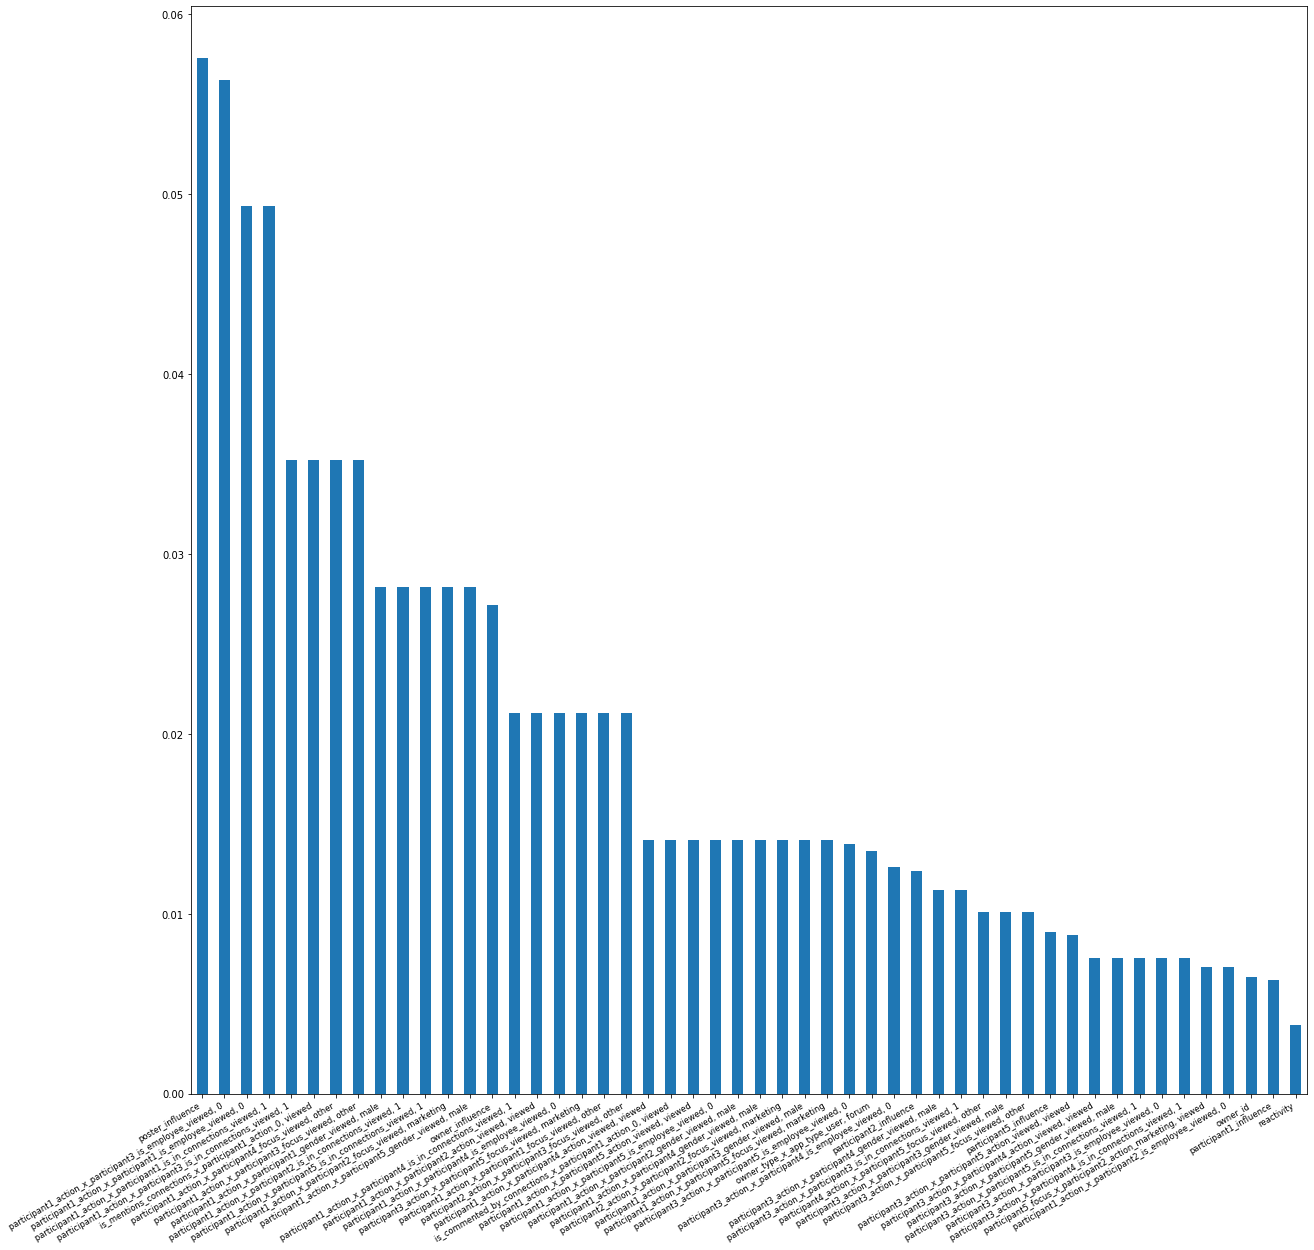

In [10]:
from sklearn.ensemble import ExtraTreesRegressor

X = train_enc_df.drop('rank', axis=1)
y = old_train_df['rank']

model = ExtraTreesRegressor()
model.fit(X, y)
# print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)

feat_importances.nlargest(50).plot(kind='bar', figsize=(20, 20))
plt.xticks(
    rotation=30,
    horizontalalignment='right',
    fontweight='light',
    fontsize='small',
)
plt.savefig('double_crosses_onehot.png')

In [11]:
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X, y = train_enc_df.drop('rank', axis=1), old_train_df['rank']

# ANOVA SVM-C
# 1) anova filter, take 3 best ranked features
anova_filter = SelectKBest(f_regression, k=3)

anova_filter.fit_transform(X, y)
anova_filter.scores_

array([ 355.866,  462.259,  355.839, ..., 1928.422, 5099.119,   70.   ])

In [12]:
influence_pairs = list(zip(anova_filter.scores_, train_enc_df.columns))
influence_pairs = sorted(influence_pairs, key=lambda x: x[0], reverse=True)

# Making readable output
num_of_important = 50
for i in range(num_of_important):
    print('{1:s} - {0:.3f}'.format(*influence_pairs[i]))

is_commented_by_connections_x_participant1_action_0, liked - 22456.171
is_liked_by_connections_x_participant1_action_0, liked - 22456.171
is_mentions_connections_x_participant1_action_0, liked - 22456.171
participant1_action_x_participant1_is_employee_liked, 1 - 22456.171
participant1_action_x_participant2_is_employee_liked, 1 - 22456.171
participant1_action_x_participant3_is_employee_liked, 1 - 22456.171
participant1_action_x_participant4_is_employee_liked, 1 - 22456.171
participant1_action_x_participant5_is_employee_liked, 1 - 22456.171
participant1_action_x_participant1_is_in_connections_liked, 1 - 22456.171
participant1_action_x_participant2_is_in_connections_liked, 1 - 22456.171
participant1_action_x_participant3_is_in_connections_liked, 1 - 22456.171
participant1_action_x_participant4_is_in_connections_liked, 1 - 22456.171
participant1_action_x_participant5_is_in_connections_liked, 1 - 22456.171
participant1_action_x_participant1_focus_liked, sales - 22456.171
participant1_action

### Ordinal Approach

In [13]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

encoder.fit(train_df.to_numpy())
encoder.categories_

[array(['calendar, 0', 'calendar, 1', 'forum, 0', 'forum, 1', 'other, 0',
        'other, 1', 'poll, 0', 'poll, 1', 'social, 0', 'social, 1',
        'wiki, 0', 'wiki, 1'], dtype=object),
 array(['calendar, 0', 'calendar, 1', 'forum, 0', 'forum, 1', 'other, 0',
        'other, 1', 'poll, 0', 'poll, 1', 'social, 0', 'social, 1',
        'wiki, 0', 'wiki, 1'], dtype=object),
 array(['calendar, 0', 'calendar, 1', 'forum, 0', 'forum, 1', 'other, 0',
        'other, 1', 'poll, 0', 'poll, 1', 'social, 0', 'social, 1',
        'wiki, 0', 'wiki, 1'], dtype=object),
 array(['calendar, 0', 'calendar, 1', 'forum, 0', 'forum, 1', 'other, 0',
        'other, 1', 'poll, 0', 'poll, 1', 'social, 1', 'wiki, 0',
        'wiki, 1'], dtype=object),
 array(['calendar, commented', 'calendar, liked', 'calendar, viewed',
        'forum, commented', 'forum, liked', 'forum, viewed',
        'other, commented', 'other, liked', 'other, viewed',
        'poll, commented', 'poll, viewed', 'social, commented',
     

In [14]:
rez = encoder.transform(train_df.to_numpy())
rez_df = pd.DataFrame(list(rez))
    
rez_df.index = train_df.index

new_feature_names = train_df.columns
rename_to_new = {old: new for old, new in zip(list(range(len(new_feature_names))), new_feature_names)}
rez_df = rez_df.rename(rename_to_new, axis=1)

rez_df.head()

,app_type_x_is_commented_by_connections,app_type_x_is_liked_by_connections,app_type_x_participant1_is_employee,app_type_x_participant1_is_in_connections,app_type_x_participant1_action,app_type_x_participant1_focus,app_type_x_participant2_focus,app_type_x_participant3_focus,app_type_x_participant4_focus,app_type_x_participant5_focus,...,participant5_gender_x_participant4_focus,participant5_is_employee_x_is_commented_by_connections,participant5_is_employee_x_participant2_is_employee,participant5_is_employee_x_participant3_focus,participant5_is_employee_x_participant5_focus,participant5_is_in_connections_x_is_commented_by_connections,participant5_is_in_connections_x_participant3_is_employee,participant5_is_in_connections_x_participant4_is_employee,participant5_is_in_connections_x_participant5_is_employee,participant5_is_in_connections_x_participant4_focus
id,,,,,,,,,,,,,,,,,,,,,
175339,4.0,5.0,5.0,5.0,7.0,8.0,9.0,8.0,8.0,8.0,...,6.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,6.0
175348,3.0,2.0,2.0,2.0,3.0,5.0,4.0,5.0,3.0,4.0,...,5.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,2.0,5.0
175353,3.0,2.0,2.0,2.0,3.0,5.0,4.0,4.0,4.0,3.0,...,6.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,2.0,6.0
175371,4.0,4.0,4.0,5.0,8.0,9.0,8.0,9.0,8.0,7.0,...,6.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,6.0
175372,4.0,4.0,4.0,5.0,8.0,9.0,8.0,9.0,8.0,7.0,...,6.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,6.0


In [15]:
train_enc_df = old_train_df.copy()
train_enc_df = train_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
train_enc_df = train_enc_df.drop(cat_cols, axis=1)

train_enc_df.head()

,posted_time,updated_time,age,updated_age,owner_id,owner_influence,number_of_likes,number_of_comments,reactivity,poster_id,...,participant5_gender_x_participant4_focus,participant5_is_employee_x_is_commented_by_connections,participant5_is_employee_x_participant2_is_employee,participant5_is_employee_x_participant3_focus,participant5_is_employee_x_participant5_focus,participant5_is_in_connections_x_is_commented_by_connections,participant5_is_in_connections_x_participant3_is_employee,participant5_is_in_connections_x_participant4_is_employee,participant5_is_in_connections_x_participant5_is_employee,participant5_is_in_connections_x_participant4_focus
id,,,,,,,,,,,,,,,,,,,,,
175339,1.514050e+12,1.514050e+12,6.315242e+10,6.315242e+10,57727,0.99973,1,0,1.00000,5,...,6.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,6.0
175348,1.514110e+12,1.515160e+12,6.309278e+10,6.204696e+10,111913,0.99977,0,2,0.12336,146,...,5.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,2.0,5.0
175353,1.514120e+12,1.515160e+12,6.309049e+10,6.204716e+10,111913,0.99977,0,3,0.12336,146,...,6.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,2.0,6.0
175371,1.514190e+12,1.514190e+12,6.301324e+10,6.301324e+10,9037,0.99949,0,0,0.00000,7,...,6.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,6.0
175372,1.514190e+12,1.514190e+12,6.301323e+10,6.301323e+10,9037,0.99949,0,0,0.00000,7,...,6.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,6.0


[0.    0.    0.    0.    0.006 0.039 0.    0.    0.004 0.    0.063 0.
 0.007 0.    0.013 0.    0.001 0.    0.001 0.    0.003 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.001 0.    0.001
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.001 0.    0.    0.    0.    0.    0.035 0.035 0.028 0.028 0.035
 0.056 0.    0.035 0.028 0.042 0.007 0.028 0.014 0.    0.021 0.028 0.049
 0.035 0.028 0.035 0.042 0.035 0.024 0.025 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.001 0.    0.    0.    0.    0.    0.001 0.    0.014 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.  

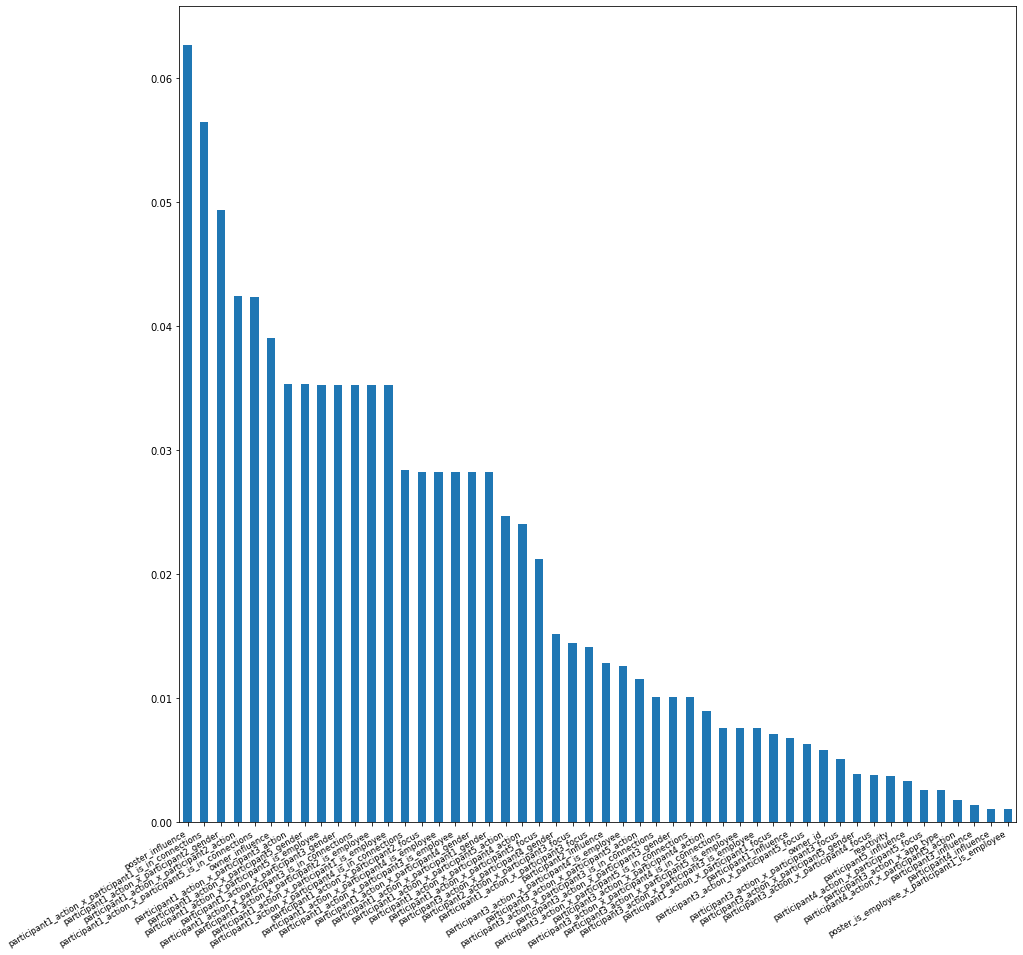

In [16]:
from sklearn.ensemble import ExtraTreesRegressor

X = train_enc_df.drop('rank', axis=1)
y = old_train_df['rank']

model = ExtraTreesRegressor()
model.fit(X, y)
print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='bar', figsize=(15, 15))
plt.xticks(
    rotation=30,
    horizontalalignment='right',
    fontweight='light',
    fontsize='small',
)
plt.savefig('double_crosses_ordinal.png')

In [17]:
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X, y = train_enc_df.drop('rank', axis=1), old_train_df['rank']

# ANOVA SVM-C
# 1) anova filter, take 3 best ranked features
anova_filter = SelectKBest(f_regression, k=3)

anova_filter.fit_transform(X, y)
anova_filter.scores_

array([  355.866,   462.259,   355.839,   462.231,     5.161,   626.1  ,
        2015.184,   805.877,   876.954,     0.706,   907.371,    58.472,
       19444.912,   942.07 , 17740.698,    75.742, 12024.881,  1087.36 ,
        7596.823,  1375.95 ,  4988.925,     0.526,     0.737,     8.859,
         271.519,  1106.42 ,   325.16 ,   117.632,   328.42 ,   400.295,
          94.312,  7760.532,  7470.113,   480.103,   309.861,   450.186,
         736.569,  1118.444,  3724.295,  2227.233,  2113.692, 14916.941,
         599.556,   503.199,   715.106,  1216.568,  1989.929,  4655.148,
        4135.788,  3947.753,  7520.155, 10378.477, 10469.622,  9558.867,
        8622.07 ,  2822.727,   118.469,   609.081,   841.447,   519.237,
         180.531,    20.116,  3605.868,  3497.955,  3043.73 ,  2681.112,
          73.129,   870.948,  2368.24 ,  1916.589,  1424.959,   999.576,
           5.299,    43.828,   119.342,  1437.437,   294.435,   343.274,
          11.309,  3355.52 ,  2692.152,  1916.446, 

In [18]:
influence_pairs = list(zip(anova_filter.scores_, train_enc_df.columns))
influence_pairs = sorted(influence_pairs, key=lambda x: x[0], reverse=True)

# Making readable output
num_of_important = 50
for i in range(num_of_important):
    print('{1:s} - {0:.3f}'.format(*influence_pairs[i]))

participant1_influence - 19444.912
participant2_influence - 17740.698
participant1_action_x_participant2_action - 15928.233
participant1_action_x_participant5_gender - 15507.175
participant1_action_x_participant3_action - 15233.071
is_commented_by_connections_x_participant4_focus - 14916.941
participant1_action_x_participant4_action - 14239.440
participant2_action_x_participant2_focus - 13919.777
participant1_action_x_participant1_focus - 13327.900
participant1_action_x_participant3_focus - 12829.414
participant1_action_x_participant4_focus - 12810.250
participant1_action_x_participant5_is_in_connections - 12277.005
participant3_influence - 12024.881
participant1_action_x_participant2_focus - 12008.987
participant1_action_x_participant4_gender - 11253.848
participant1_action_x_participant3_gender - 11187.281
participant1_action_x_participant3_is_in_connections - 11054.463
participant1_action_x_participant4_is_in_connections - 11049.434
participant1_action_x_participant2_gender - 11039.

## Triple Crosses

In [19]:
def cartesian_product_of_3_series(series_1, series_2, series_3, df):
    return df.apply(lambda row: f"{row[series_1]}, {row[series_2]}, {row[series_3]}", axis=1)
    
train_df = pd.read_csv('training.csv', index_col='id')
cartesian_product_of_3_series('app_type', 'is_commented_by_connections',
                              'is_liked_by_connections', train_df.iloc[:5])

id
175339    other, 0, 1
175348    forum, 1, 0
175353    forum, 1, 0
175371    other, 0, 0
175372    other, 0, 0
dtype: object

In [20]:
def create_triple_feature_crosses(triple_crosses_vocab, df):
    res_df = pd.DataFrame()
    used_triples = []
    for feature_1, val_1 in triple_crosses_vocab.items():
        for feature_2, val_2 in val_1.items():
            for feature_3 in val_2:
                tmp_ls = [feature_1, feature_2, feature_3]
                if all([(x, y, z) not in used_triples for x in tmp_ls for y in tmp_ls 
                        for z in tmp_ls if x != y and y != z and x != z]) and \
                        feature_2 in cat_cols and feature_3 in cat_cols:
                
                    name = feature_1 + '_x_' + feature_2 + '_x_' + feature_3
                    res_df[name] = cartesian_product_of_3_series(feature_1, feature_2, 
                                                                 feature_3, df)
                    used_triples.append((feature_1, feature_2, feature_3))
    return res_df

old_train_df = train_df
train_df = create_triple_feature_crosses(triple_crosses, train_df)

### OneHot Approach for Encoding

In [21]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
# onehot_features = [i for i in cat_cols if 'is_' not in i and 'order' not in i]

encoder.fit(train_df.to_numpy())
encoder.categories_

[array(['calendar, 0, commented', 'calendar, 0, liked',
        'calendar, 0, viewed', 'calendar, 1, commented',
        'calendar, 1, liked', 'forum, 0, commented', 'forum, 0, liked',
        'forum, 0, viewed', 'forum, 1, commented', 'forum, 1, liked',
        'other, 0, commented', 'other, 0, liked', 'other, 0, viewed',
        'other, 1, commented', 'other, 1, liked', 'poll, 0, commented',
        'poll, 0, viewed', 'poll, 1, commented', 'social, 0, commented',
        'social, 0, viewed', 'social, 1, commented', 'social, 1, liked',
        'wiki, 0, commented', 'wiki, 0, liked', 'wiki, 0, viewed',
        'wiki, 1, commented', 'wiki, 1, liked'], dtype=object),
 array(['calendar, 0, commented', 'calendar, 0, viewed',
        'calendar, 1, commented', 'calendar, 1, liked',
        'calendar, 1, viewed', 'forum, 0, commented', 'forum, 0, liked',
        'forum, 0, viewed', 'forum, 1, commented', 'forum, 1, liked',
        'forum, 1, viewed', 'other, 0, commented', 'other, 0, liked',


In [22]:
rez = encoder.transform(train_df.to_numpy())
rez_df = pd.DataFrame(rez.toarray())
    
rez_df.index = train_df.index

new_feature_names = encoder.get_feature_names(train_df.columns)
rename_to_new = {old: new for old, new in zip(list(range(len(new_feature_names))), new_feature_names)}
rez_df = rez_df.rename(rename_to_new, axis=1)

rez_df.head()

,"app_type_x_is_liked_by_connections_x_participant1_action_calendar, 0, commented","app_type_x_is_liked_by_connections_x_participant1_action_calendar, 0, liked","app_type_x_is_liked_by_connections_x_participant1_action_calendar, 0, viewed","app_type_x_is_liked_by_connections_x_participant1_action_calendar, 1, commented","app_type_x_is_liked_by_connections_x_participant1_action_calendar, 1, liked","app_type_x_is_liked_by_connections_x_participant1_action_forum, 0, commented","app_type_x_is_liked_by_connections_x_participant1_action_forum, 0, liked","app_type_x_is_liked_by_connections_x_participant1_action_forum, 0, viewed","app_type_x_is_liked_by_connections_x_participant1_action_forum, 1, commented","app_type_x_is_liked_by_connections_x_participant1_action_forum, 1, liked",...,"poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, engineering, 0","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, engineering, 1","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, marketing, 0","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, marketing, 1","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, none, 0","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, none, 1","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, other, 0","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, other, 1","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, sales, 0","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, sales, 1"
id,,,,,,,,,,,,,,,,,,,,,
175339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175348,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175353,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
175371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
train_enc_df = old_train_df.copy()
train_enc_df = train_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
train_enc_df = train_enc_df.drop(cat_cols, axis=1)

train_enc_df.head()

,posted_time,updated_time,age,updated_age,owner_id,owner_influence,number_of_likes,number_of_comments,reactivity,poster_id,...,"poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, engineering, 0","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, engineering, 1","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, marketing, 0","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, marketing, 1","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, none, 0","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, none, 1","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, other, 0","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, other, 1","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, sales, 0","poster_is_in_connections_x_poster_focus_x_participant3_is_employee_1, sales, 1"
id,,,,,,,,,,,,,,,,,,,,,
175339,1.514050e+12,1.514050e+12,6.315242e+10,6.315242e+10,57727,0.99973,1,0,1.00000,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175348,1.514110e+12,1.515160e+12,6.309278e+10,6.204696e+10,111913,0.99977,0,2,0.12336,146,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175353,1.514120e+12,1.515160e+12,6.309049e+10,6.204716e+10,111913,0.99977,0,3,0.12336,146,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
175371,1.514190e+12,1.514190e+12,6.301324e+10,6.301324e+10,9037,0.99949,0,0,0.00000,7,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175372,1.514190e+12,1.514190e+12,6.301323e+10,6.301323e+10,9037,0.99949,0,0,0.00000,7,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


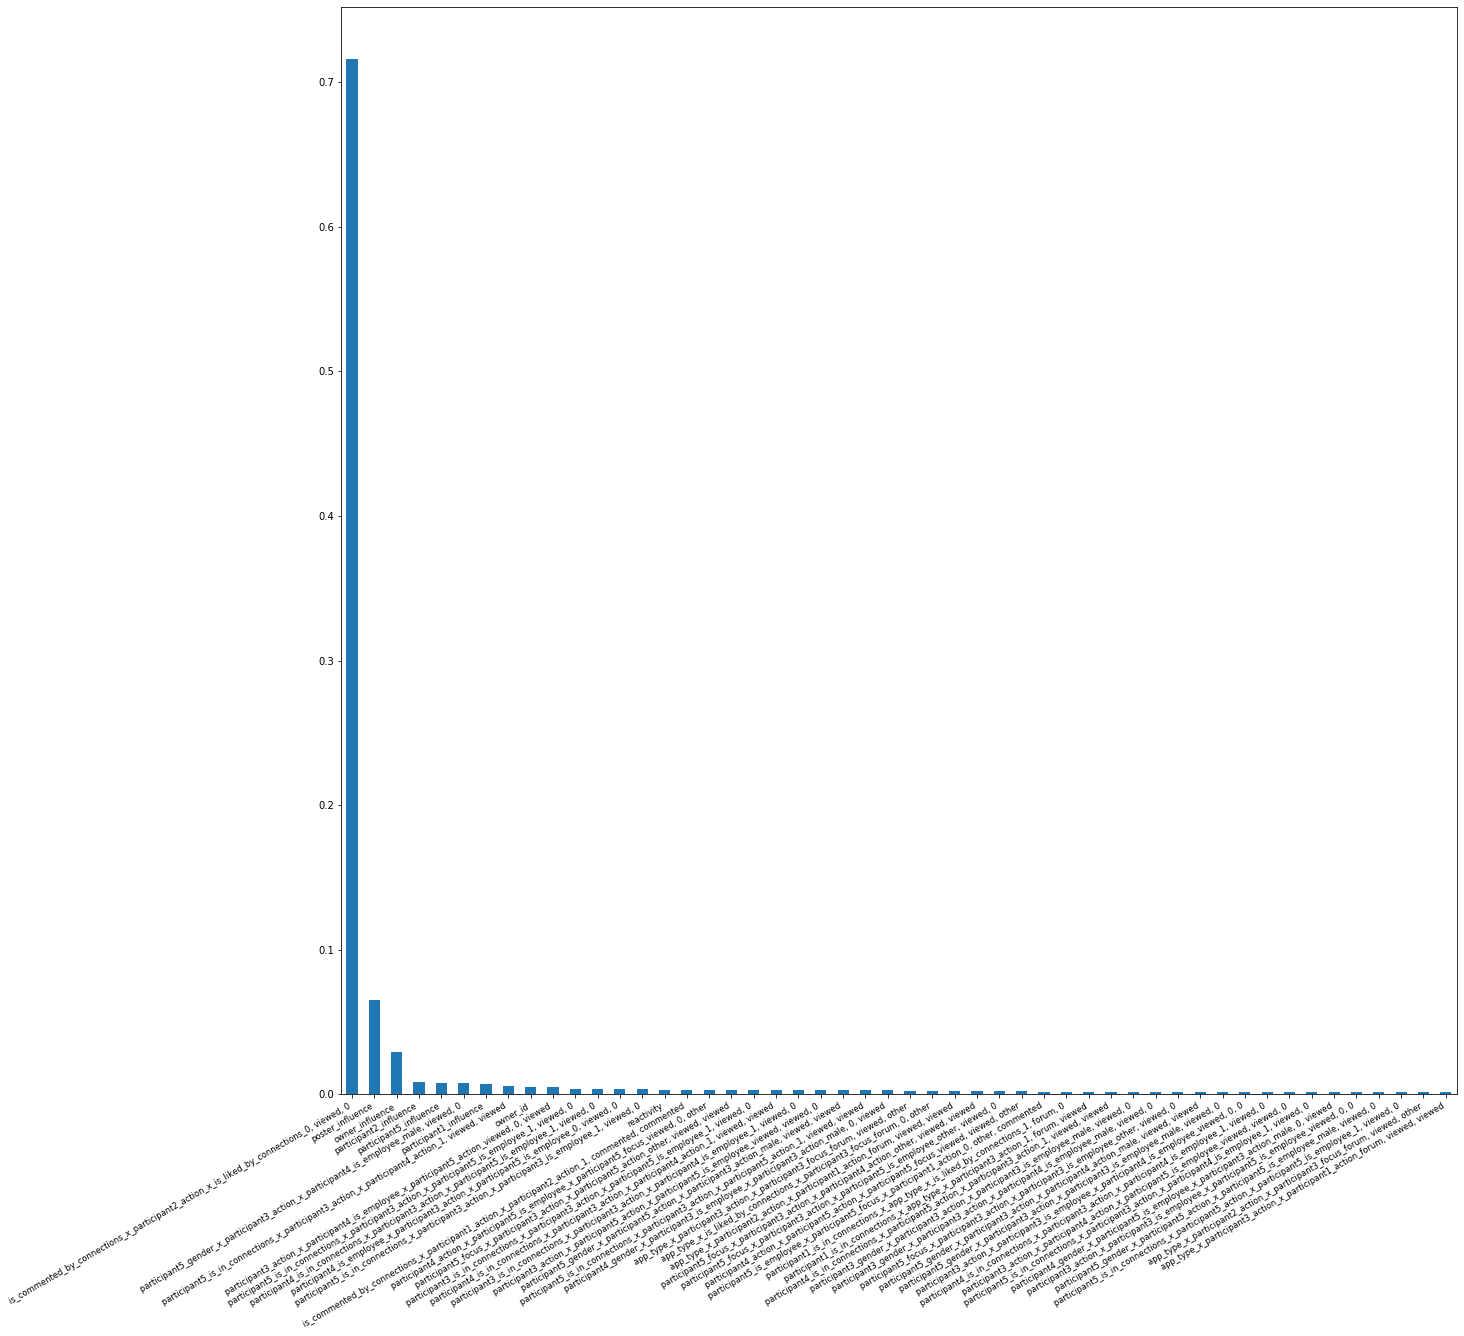

In [24]:
from sklearn.ensemble import ExtraTreesRegressor

X = train_enc_df.drop('rank', axis=1)
y = old_train_df['rank']

model = ExtraTreesRegressor()
model.fit(X, y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)

feat_importances.nlargest(50).plot(kind='bar', figsize=(20, 20))
plt.xticks(
    rotation=30,
    horizontalalignment='right',
    fontweight='light',
    fontsize='small',
)
plt.savefig('triple_crosses_onehot.png')

In [25]:
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X, y = train_enc_df.drop('rank', axis=1), old_train_df['rank']

# ANOVA SVM-C
# 1) anova filter, take 3 best ranked features
anova_filter = SelectKBest(f_regression, k=3)

anova_filter.fit_transform(X, y)
anova_filter.scores_

array([355.866, 462.259, 355.839, ..., 116.348,  53.857,  96.318])

In [26]:
influence_pairs = list(zip(anova_filter.scores_, train_enc_df.columns))
influence_pairs = sorted(influence_pairs, key=lambda x: x[0], reverse=True)

# Making readable output
num_of_important = 50
for i in range(num_of_important):
    print('{1:s} - {0:.3f}'.format(*influence_pairs[i]))

is_commented_by_connections_x_participant2_action_x_is_liked_by_connections_0, liked, 1 - 23753.484
is_liked_by_connections_x_participant1_is_employee_x_participant2_action_0, 0, liked - 23751.871
is_commented_by_connections_x_participant2_action_x_participant1_is_employee_0, liked, 1 - 22703.624
participant1_focus_x_participant1_is_employee_x_participant2_action_other, 0, liked - 22601.681
is_commented_by_connections_x_participant1_action_x_participant2_action_0, liked, viewed - 22456.171
is_commented_by_connections_x_participant1_action_x_participant3_action_0, liked, viewed - 22456.171
is_commented_by_connections_x_participant1_action_x_participant3_is_employee_0, liked, 1 - 22456.171
is_commented_by_connections_x_participant1_action_x_participant4_is_employee_0, liked, 1 - 22456.171
is_commented_by_connections_x_participant1_action_x_participant5_focus_0, liked, sales - 22456.171
is_commented_by_connections_x_participant3_focus_x_participant2_action_0, other, liked - 22456.171
is_l

### Ordinal Approach

In [27]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

encoder.fit(train_df.to_numpy())
encoder.categories_

[array(['calendar, 0, commented', 'calendar, 0, liked',
        'calendar, 0, viewed', 'calendar, 1, commented',
        'calendar, 1, liked', 'forum, 0, commented', 'forum, 0, liked',
        'forum, 0, viewed', 'forum, 1, commented', 'forum, 1, liked',
        'other, 0, commented', 'other, 0, liked', 'other, 0, viewed',
        'other, 1, commented', 'other, 1, liked', 'poll, 0, commented',
        'poll, 0, viewed', 'poll, 1, commented', 'social, 0, commented',
        'social, 0, viewed', 'social, 1, commented', 'social, 1, liked',
        'wiki, 0, commented', 'wiki, 0, liked', 'wiki, 0, viewed',
        'wiki, 1, commented', 'wiki, 1, liked'], dtype=object),
 array(['calendar, 0, commented', 'calendar, 0, viewed',
        'calendar, 1, commented', 'calendar, 1, liked',
        'calendar, 1, viewed', 'forum, 0, commented', 'forum, 0, liked',
        'forum, 0, viewed', 'forum, 1, commented', 'forum, 1, liked',
        'forum, 1, viewed', 'other, 0, commented', 'other, 0, liked',


In [28]:
rez = encoder.transform(train_df.to_numpy())
rez_df = pd.DataFrame(list(rez))
    
rez_df.index = train_df.index

new_feature_names = train_df.columns
rename_to_new = {old: new for old, new in zip(list(range(len(new_feature_names))), new_feature_names)}
rez_df = rez_df.rename(rename_to_new, axis=1)

rez_df.head()

,app_type_x_is_liked_by_connections_x_participant1_action,app_type_x_is_liked_by_connections_x_participant2_action,app_type_x_is_liked_by_connections_x_participant3_action,app_type_x_is_liked_by_connections_x_participant4_action,app_type_x_is_liked_by_connections_x_participant3_focus,app_type_x_participant1_is_employee_x_participant1_focus,app_type_x_participant1_is_employee_x_participant2_action,app_type_x_participant2_action_x_is_commented_by_connections,app_type_x_participant2_action_x_participant1_action,app_type_x_participant2_action_x_participant3_action,...,poster_is_employee_x_participant2_is_employee_x_participant2_action,poster_is_employee_x_participant2_is_employee_x_participant3_action,poster_is_employee_x_participant2_is_employee_x_participant5_action,poster_is_employee_x_participant3_is_employee_x_participant2_action,poster_is_employee_x_participant3_is_employee_x_participant3_action,poster_is_employee_x_participant3_is_employee_x_participant4_action,poster_is_employee_x_participant3_is_employee_x_participant5_action,poster_is_employee_x_participant3_is_employee_x_participant3_focus,poster_is_in_connections_x_poster_focus_x_poster_is_employee,poster_is_in_connections_x_poster_focus_x_participant3_is_employee
id,,,,,,,,,,,,,,,,,,,,,
175339,14.0,16.0,16.0,15.0,18.0,17.0,17.0,15.0,16.0,17.0,...,7.0,8.0,8.0,7.0,7.0,8.0,8.0,9.0,9.0,8.0
175348,5.0,5.0,7.0,6.0,7.0,6.0,6.0,6.0,6.0,8.0,...,8.0,11.0,11.0,5.0,7.0,8.0,8.0,10.0,9.0,8.0
175353,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,8.0,9.0,11.0,8.0,8.0,11.0,11.0,13.0,9.0,9.0
175371,12.0,13.0,13.0,12.0,15.0,14.0,14.0,15.0,17.0,17.0,...,7.0,8.0,8.0,7.0,7.0,8.0,8.0,10.0,9.0,8.0
175372,12.0,13.0,13.0,12.0,15.0,14.0,14.0,15.0,17.0,17.0,...,7.0,8.0,8.0,7.0,7.0,8.0,8.0,10.0,9.0,8.0


In [29]:
train_enc_df = old_train_df.copy()
train_enc_df = train_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
train_enc_df = train_enc_df.drop(cat_cols, axis=1)

train_enc_df.head()

,posted_time,updated_time,age,updated_age,owner_id,owner_influence,number_of_likes,number_of_comments,reactivity,poster_id,...,poster_is_employee_x_participant2_is_employee_x_participant2_action,poster_is_employee_x_participant2_is_employee_x_participant3_action,poster_is_employee_x_participant2_is_employee_x_participant5_action,poster_is_employee_x_participant3_is_employee_x_participant2_action,poster_is_employee_x_participant3_is_employee_x_participant3_action,poster_is_employee_x_participant3_is_employee_x_participant4_action,poster_is_employee_x_participant3_is_employee_x_participant5_action,poster_is_employee_x_participant3_is_employee_x_participant3_focus,poster_is_in_connections_x_poster_focus_x_poster_is_employee,poster_is_in_connections_x_poster_focus_x_participant3_is_employee
id,,,,,,,,,,,,,,,,,,,,,
175339,1.514050e+12,1.514050e+12,6.315242e+10,6.315242e+10,57727,0.99973,1,0,1.00000,5,...,7.0,8.0,8.0,7.0,7.0,8.0,8.0,9.0,9.0,8.0
175348,1.514110e+12,1.515160e+12,6.309278e+10,6.204696e+10,111913,0.99977,0,2,0.12336,146,...,8.0,11.0,11.0,5.0,7.0,8.0,8.0,10.0,9.0,8.0
175353,1.514120e+12,1.515160e+12,6.309049e+10,6.204716e+10,111913,0.99977,0,3,0.12336,146,...,8.0,9.0,11.0,8.0,8.0,11.0,11.0,13.0,9.0,9.0
175371,1.514190e+12,1.514190e+12,6.301324e+10,6.301324e+10,9037,0.99949,0,0,0.00000,7,...,7.0,8.0,8.0,7.0,7.0,8.0,8.0,10.0,9.0,8.0
175372,1.514190e+12,1.514190e+12,6.301323e+10,6.301323e+10,9037,0.99949,0,0,0.00000,7,...,7.0,8.0,8.0,7.0,7.0,8.0,8.0,10.0,9.0,8.0


[0.    0.    0.    0.    0.006 0.036 0.    0.    0.004 0.    0.066 0.
 0.013 0.    0.012 0.    0.    0.    0.001 0.    0.001 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.028 0.021 0.007 0.021
 0.007 0.021 0.01

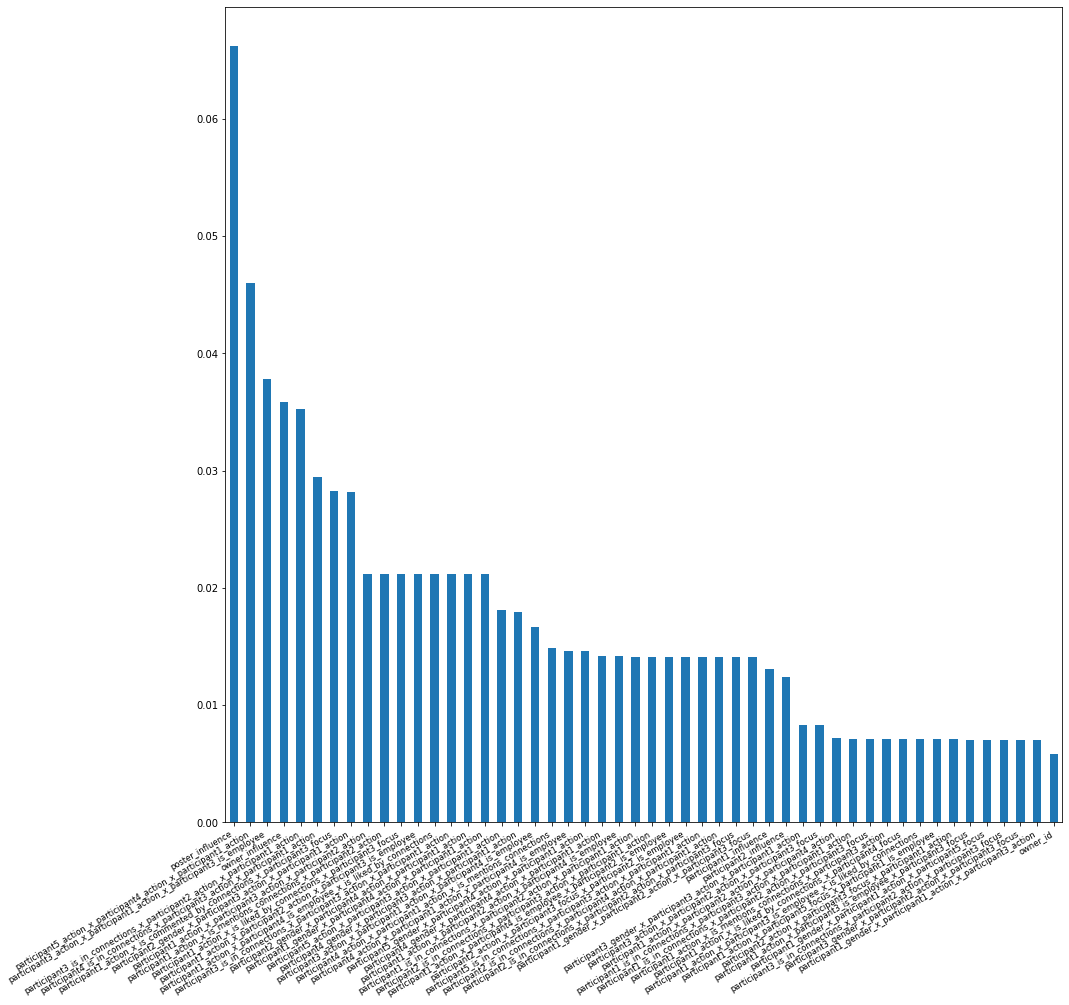

In [30]:
from sklearn.ensemble import ExtraTreesRegressor

X = train_enc_df.drop('rank', axis=1)
y = old_train_df['rank']

model = ExtraTreesRegressor()
model.fit(X, y)
print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='bar', figsize=(15, 15))
plt.xticks(
    rotation=30,
    horizontalalignment='right',
    fontweight='light',
    fontsize='small',
)
plt.savefig('triple_crosses_ordinal.png')

In [31]:
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X, y = train_enc_df.drop('rank', axis=1), old_train_df['rank']

# ANOVA SVM-C
# 1) anova filter, take 3 best ranked features
anova_filter = SelectKBest(f_regression, k=3)

anova_filter.fit_transform(X, y)
anova_filter.scores_

array([  355.866,   462.259,   355.839,   462.231,     5.161,   626.1  ,
        2015.184,   805.877,   876.954,     0.706,   907.371,    58.472,
       19444.912,   942.07 , 17740.698,    75.742, 12024.881,  1087.36 ,
        7596.823,  1375.95 ,  4988.925,    20.932,    14.546,    21.929,
           6.079,    31.517,    12.573,    69.736,   852.618,  1675.327,
        1325.282,  1234.718,  1143.44 ,  1576.563,  1489.298,  1298.507,
        1485.278,  1097.319,  1010.385,   716.499,   685.918,  1216.398,
        1240.696,    54.102,   107.981,   720.961,   622.947,   235.278,
        1049.164,   154.792,   708.438,   509.155,   479.8  ,   404.804,
         327.623,    87.024,   178.774,   306.426,   862.726,   285.967,
         433.109,   224.413,   205.253,  3289.622,  1051.129,  1532.653,
        2986.017,  2987.907,  2992.658,  1171.123,  1063.039,  1611.223,
        2854.242,  2809.15 ,   337.039,  1948.532,   817.214,  1204.238,
        1295.84 ,   137.05 ,   195.309,  6099.92 , 

In [32]:
influence_pairs = list(zip(anova_filter.scores_, train_enc_df.columns))
influence_pairs = sorted(influence_pairs, key=lambda x: x[0], reverse=True)

# Making readable output
num_of_important = 50
for i in range(num_of_important):
    print('{1:s} - {0:.3f}'.format(*influence_pairs[i]))

participant5_action_x_is_liked_by_connections_x_participant1_is_employee - 21483.086
participant1_influence - 19444.912
participant2_influence - 17740.698
participant5_action_x_participant2_is_employee_x_participant1_focus - 16602.004
participant5_gender_x_participant3_action_x_is_liked_by_connections - 16079.177
participant2_action_x_participant3_action_x_participant4_is_employee - 15995.799
participant5_is_in_connections_x_participant3_action_x_is_liked_by_connections - 15482.703
participant3_is_in_connections_x_participant2_action_x_is_liked_by_connections - 15461.334
participant4_gender_x_participant3_action_x_is_liked_by_connections - 15447.903
participant3_action_x_is_liked_by_connections_x_participant3_is_employee - 14679.943
participant4_action_x_is_liked_by_connections_x_participant4_is_employee - 14515.870
participant3_gender_x_participant3_action_x_is_liked_by_connections - 14505.513
participant4_is_in_connections_x_participant3_action_x_is_liked_by_connections - 14361.219
p